# Intervention liquidity

This category group contains real-time measures of central bank interventions and liquidity expansion. The main composite indicator measures the estimated growth of the monetary base related to central bank interventions in FX and security markets. The data series' measure recorded changes, not announcements.

## Currency reserve expansion as % of GDP

**Ticker**: CRESFXGDP_NSA_D1M1ML1 / _D1M1ML3 / _D1M1ML6

**Label**: FX reserves expansion as % of GDP, difference: over the last month / over 3 months / over 6 months

**Definition**: Change of FX reserves as % of nominal GDP, difference: over the last month / over 3 months / over 6 months

**Notes**:

* FX reserves comprise foreign-currency denominated deposits, securities and cash. They do not include gold, special drawing rights, and IMF reserve positions, which would be included in broader currency reserve concepts.
* The ultimate sources of the reserve data are the national central bank balance sheets.
* The 1-year moving average of the nominal GDP is based on published quarterly national accounts with extrapolation up to the latest month for which reserve data has been released.

## Domestic securities purchase expansion as % of GDP

**Ticker**: SPACSGDP_NSA_D1M1ML1 / _D1M1ML3 / _D1M1ML6

**Label**: Security purchase account expansion as % of GDP, difference: over the last month / over 3 months / over 6 months

**Definition**: Change of security purchase account as % of nominal GDP, difference: over the last month / over 3 months / over 6 months

**Notes**:

* Security purchase account series are available for those countries which have been conducting quantitative easing / asset purchase programmes: Australia, Canada, the Eurozone, Great Britain, Japan, New Zealand, Sweden, the United States.
* From January 2019 onwards, the Term Funding Scheme (TFS) drawings were moved to the Bank of England's balance sheet and therefore no longer reported as part of the 'Asset Purchase Facility'. To ensure consistency, the definition of 'Asset Purchase Facility' was narrowed down to exclude TFS drawings from the beginning.
* For Japan, the indicator also includes pecuniary trusts (stocks, index-linked ETFs and REITs held as trust property).
* For New Zealand, the indicator only includes the 'Large Scale Asset Purchase' (LSAP). It does not include 'Bond Market Liquidity Support' or early repurchases.
* The 1-year moving average of the nominal GDP is based on published quarterly national accounts with extrapolation up to the latest month for which security purchase data has been released.

## Monetary base expansion as % of GDP

**Ticker**: MBASEGDP_SA_D1M1ML1 / _D1M1ML3 / _D1M1ML6

**Label**: Monetary base expansion as % of GDP, difference: over the last month / over 3 months / over 6 months

**Definition**: Change in monetary base as % of nominal GDP, difference: over the last month / over 3 months / over 6 months

**Notes**:

* The monetary base is conceptually money that is directly created by the monetary authority and consists mostly of cash in circulation and deposits held with the central bank. Due to its pronounced seasonality in some countries, the monetary base has been seasonally adjusted on a real-time vintage basis.
* The ultimate source of the monetary base data are the national central bank balance sheets.

## Intervention-driven liquidity expansion as % of GDP

**Ticker**: INTLIQGDP_NSA_D1M1ML1 / _D1M1ML3 / _D1M1ML6

**Label**: Intervention-driven liquidity expansion as % of GDP, difference: over the last month / over 3 months / over 6 months

**Definition**: Change in intervention-driven liquidity as % of nominal GDP, difference: over the last month / over 3 months / over 6 months

**Notes**:

* Intervention-driven liquidity expansion is an estimate of how much central bank liquidity has been added as a consequence of central bank interventions. Two types of central bank interventions are considered: unsterilized FX interventions and domestic security purchases. Intervention-driven expansion is assumed to have occured if the sum of the intervention accounts (FX reserves and special purchase accounts) and the monetary base have both increased over a specific observation period. If both are negative, the expansion is assumed to have been negative. If intervention accounts and monetary base have moved in opposite directions, intervention liquidity expansion is estimated to be zero. The estimated amount of intervention is the smaller of the absolute change in the intervention accounts and the monetary base.
* See [Appendix 1](#appendix1) for the formula.

# Imports

Only the standard Python data science packages and the specialized `macrosynergy` package are needed.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import json
import yaml

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn

from macrosynergy.download import JPMaQSDownload

from timeit import default_timer as timer
from datetime import timedelta, date, datetime

import warnings

warnings.simplefilter("ignore")

<IPython.core.display.Javascript object>

The `JPMaQS` indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying *ticker strings*, formed by appending an indicator category code `<category>` to a currency area code `<cross_section>`. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where `<info>` denotes the time series of information for the given cross-section and category. The following types of information are available:

* `value` giving the latest available values for the indicator
* `eop_lag` referring to days elapsed since the end of the observation period
* `mop_lag` referring to the number of days elapsed since the mean observation period
* `grade` denoting a grade of the observation, giving a metric of real time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded.

In [2]:
# Cross-sections of interest

cids_dmca = [
    "AUD",
    "CAD",
    "CHF",
    "EUR",
    "GBP",
    "JPY",
    "NOK",
    "NZD",
    "SEK",
    "USD",
]  # DM currency areas
cids_dmec = ["DEM", "ESP", "FRF", "ITL", "NLG"]  # DM euro area countries
cids_latm = ["BRL", "COP", "CLP", "MXN", "PEN"]  # Latam countries
cids_emea = ["CZK", "HUF", "ILS", "PLN", "RON", "RUB", "TRY", "ZAR"]  # EMEA countries
cids_emas = [
    "CNY",
    "IDR",
    "INR",
    "KRW",
    "MYR",
    "PHP",
    "SGD",
    "THB",
    "TWD",
]  # EM Asia countries

cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas

cids = sorted(cids_dm + cids_em)

<IPython.core.display.Javascript object>

In [3]:
main = [
    "CRESFXGDP_NSA_D1M1ML1",
    "CRESFXGDP_NSA_D1M1ML3",
    "CRESFXGDP_NSA_D1M1ML6",
    "SPACSGDP_NSA_D1M1ML1",
    "SPACSGDP_NSA_D1M1ML3",
    "SPACSGDP_NSA_D1M1ML6",
    "MBASEGDP_SA_D1M1ML1",
    "MBASEGDP_SA_D1M1ML3",
    "MBASEGDP_SA_D1M1ML6",
    "INTLIQGDP_NSA_D1M1ML1",
    "INTLIQGDP_NSA_D1M1ML3",
    "INTLIQGDP_NSA_D1M1ML6",
]

econ = ["REER_NSA_P1M60ML1"]  # economic context

mark = [
    "FXXR_NSA",
    "FXXR_VT10",
    "FXXRHvGDRB_NSA",
    "EQXR_NSA",
    "EQXR_VT10",
    "FXTARGETED_NSA",
    "FXUNTRADABLE_NSA",
]  # market links

mark = [
    "FXCRR_NSA",
    "FXXR_NSA",
    "FXXRHvGDRB_NSA",
    "FXXR_VT10",
    "EQXR_VT10",
    "EQXR_NSA",
    "DU05YXR_NSA",
    "DU05YXR_VT10",
    "FXTARGETED_NSA",
    "FXUNTRADABLE_NSA",
]  # market links


xcats = main + econ + mark

<IPython.core.display.Javascript object>

In [4]:
# Download series from J.P. Morgan DataQuery by tickers

start_date = "2000-01-01"
tickers = [cid + "_" + xcat for cid in cids for xcat in xcats]
print(f"Maximum number of tickers is {len(tickers)}")

# Retrieve credentials

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

# Download from DataQuery

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as downloader:
    start = timer()
    df = downloader.download(
        tickers=tickers,
        start_date=start_date,
        metrics=["value", "eop_lag", "mop_lag", "grading"],
        suppress_warning=True,
        show_progress=True,
    )
    end = timer()

dfd = df

print("Download time from DQ: " + str(timedelta(seconds=end - start)))

Maximum number of tickers is 851
Timestamp UTC:  2023-07-19 14:42:35
Connection successful!
Number of expressions requested: 3404


Requesting data: 100%|███████████████████████████████████████████████████████████████| 171/171 [00:54<00:00,  3.12it/s]


Download time from DQ: 0:02:42.445682


<IPython.core.display.Javascript object>

# Availability

In [5]:
cids_exp = sorted(
    list(set(cids) - set(cids_dmec + ["HKD"]))
)  # cids expected in category panels
cats = list(
    set(main)
    - set(["SPACSGDP_NSA_D1M1ML1", "SPACSGDP_NSA_D1M1ML3", "SPACSGDP_NSA_D1M1ML6"])
)
msm.missing_in_df(dfd, xcats=cats, cids=cids_exp)

cids_spacs = ["EUR", "AUD", "CAD", "GBP", "JPY", "NZD", "SEK", "USD"]
msm.missing_in_df(
    dfd,
    xcats=["SPACSGDP_NSA_D1M1ML1", "SPACSGDP_NSA_D1M1ML3", "SPACSGDP_NSA_D1M1ML6"],
    cids=cids_spacs,
)

Missing xcats across df:  []
Missing cids for CRESFXGDP_NSA_D1M1ML1:  []
Missing cids for CRESFXGDP_NSA_D1M1ML3:  []
Missing cids for CRESFXGDP_NSA_D1M1ML6:  []
Missing cids for INTLIQGDP_NSA_D1M1ML1:  []
Missing cids for INTLIQGDP_NSA_D1M1ML3:  []
Missing cids for INTLIQGDP_NSA_D1M1ML6:  []
Missing cids for MBASEGDP_SA_D1M1ML1:  []
Missing cids for MBASEGDP_SA_D1M1ML3:  []
Missing cids for MBASEGDP_SA_D1M1ML6:  []
Missing xcats across df:  []
Missing cids for SPACSGDP_NSA_D1M1ML1:  []
Missing cids for SPACSGDP_NSA_D1M1ML3:  []
Missing cids for SPACSGDP_NSA_D1M1ML6:  []


<IPython.core.display.Javascript object>

Quantamental indicators of intervention liquidity are typically available by 2000, with exception of 'domestic securities purchase expansion as % of GDP' (`SPACSGDP_NSA_D1M1ML1` / `_D1M1ML3` / `_D1M1ML6`). This is the case for all developed markets and most emerging markets. 

'Domestic securities purchase expansion as % of GDP' is only available for Australia, Canada, the Eurozone, Great Britain, Japan, New Zealand, Sweden and the United States. Data is available from 2000 for only the United States and Canada. History for all other available cross-sections begins after 2010.

For the explanation of currency symbols, which are related to currency areas or countries for which categories are available, please view [**Appendix 2**](#appendix1).

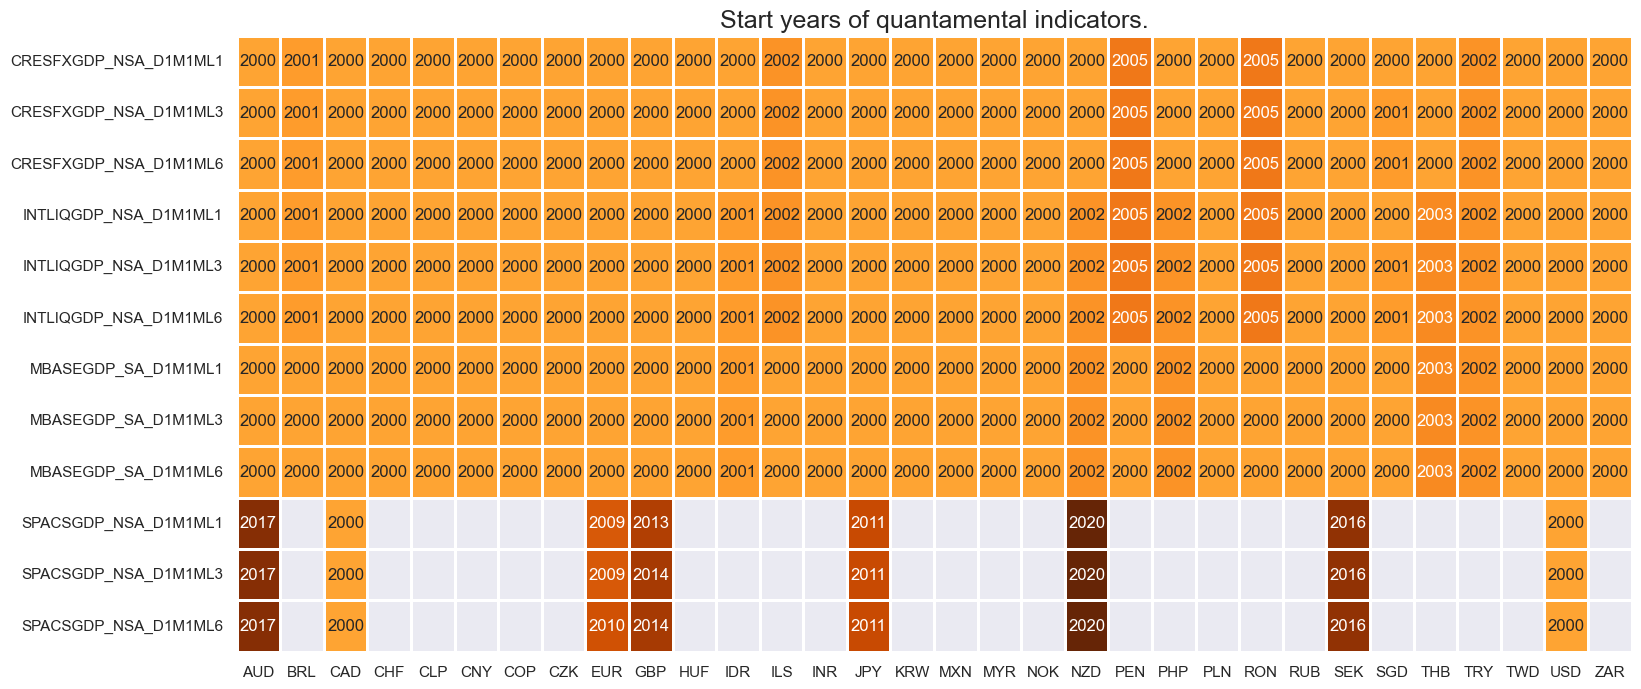

Last updated: 2023-07-19


<IPython.core.display.Javascript object>

In [6]:
xcatx = main
cidx = cids_exp

dfx = msm.reduce_df(dfd, xcats=xcatx, cids=cidx)
dfs = msm.check_startyears(
    dfx,
)
msm.visual_paneldates(dfs, size=(18, 8))

print("Last updated:", date.today())

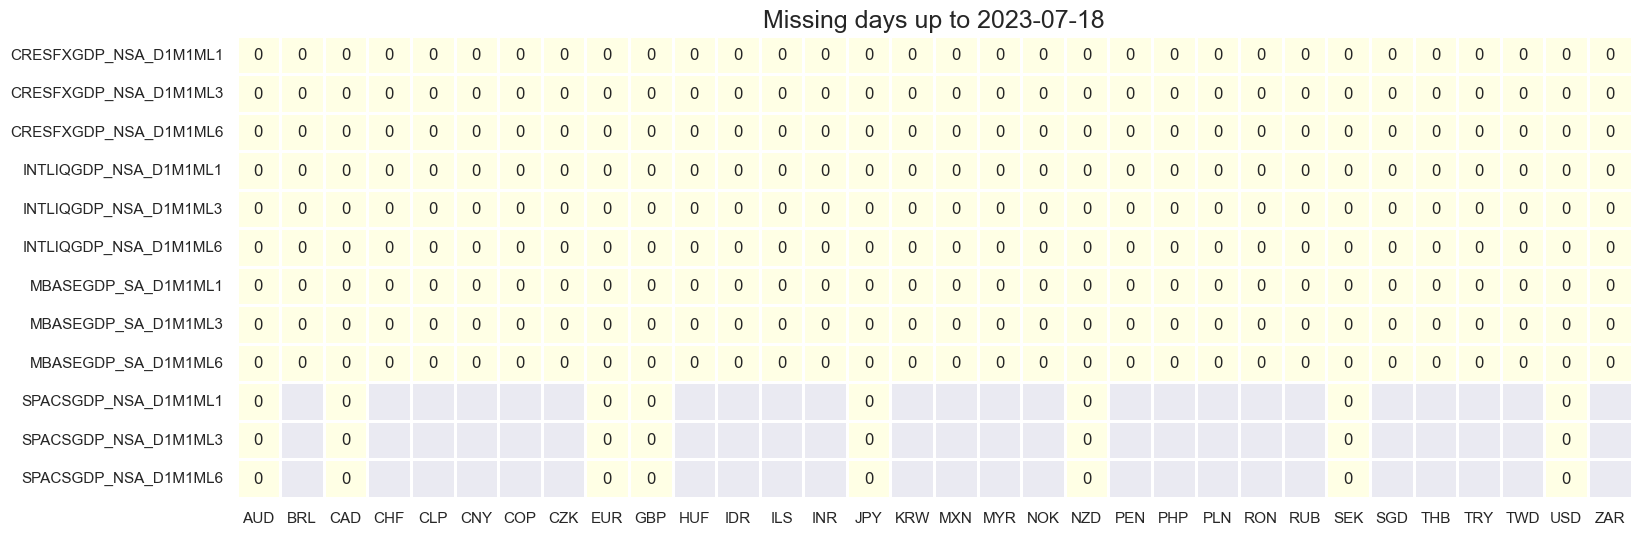

<IPython.core.display.Javascript object>

In [7]:
xcatx = main
cidx = cids_exp

plot = msm.check_availability(
    dfd, xcats=xcatx, cids=cidx, start_size=(18, 4), start_years=False
)

Average vintage grading is consistent within the category groups: currency reserve expansion, monetary base expansion and intervention-driven liquidity expansion.  Whilst the currency reserve expansion indicators comprise a substantial proportion of Grade 3 data, the monetary base and intervention-driven liquidity indicator categories are, on average, higher-graded.

Amongst domestic securities purchase expansion indicators, only data for New Zealand attains the highest (or close to the highest) grades. 

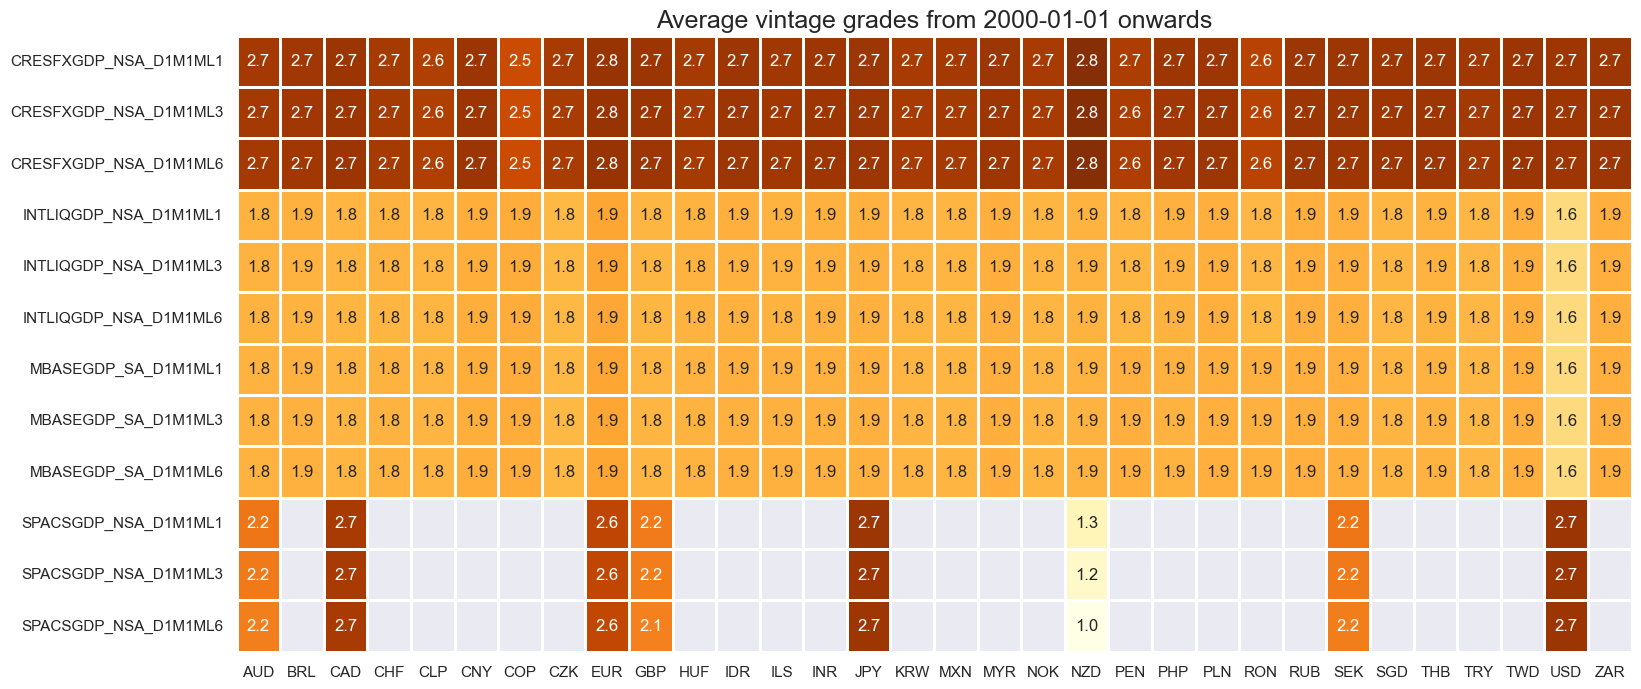

<IPython.core.display.Javascript object>

In [8]:
xcatx = main
cidx = cids_exp

plot = msp.heatmap_grades(
    dfd,
    xcats=xcatx,
    cids=cidx,
    size=(18, 8),
    title=f"Average vintage grades from {start_date} onwards",
)

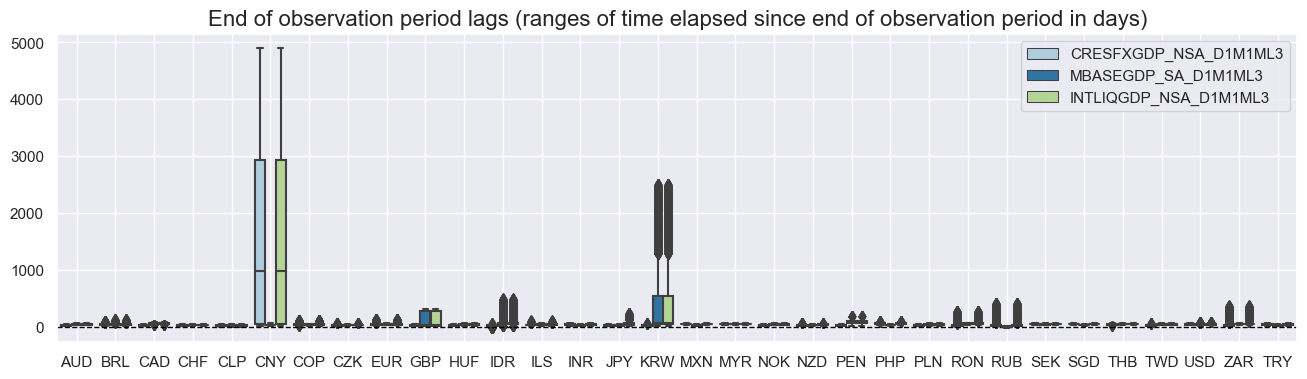

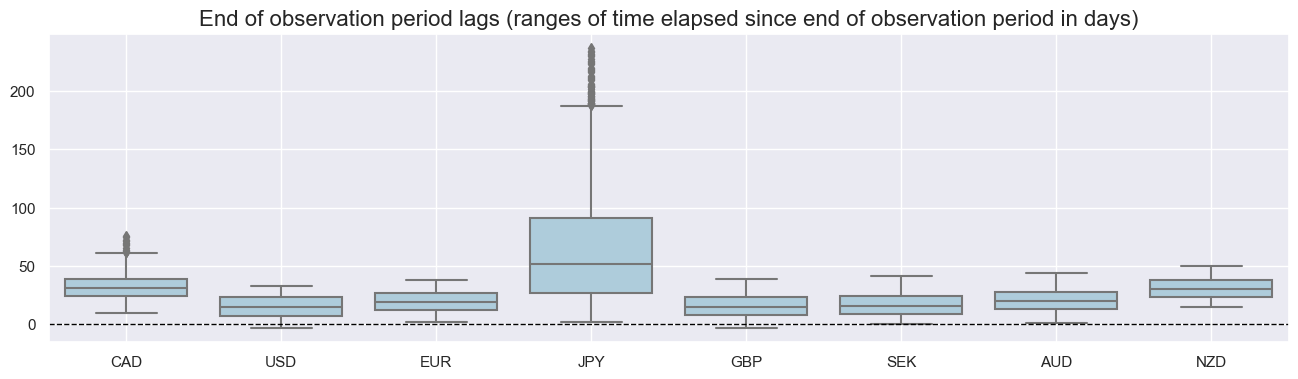

<IPython.core.display.Javascript object>

In [9]:
msp.view_ranges(
    dfd,
    xcats=["CRESFXGDP_NSA_D1M1ML3", "MBASEGDP_SA_D1M1ML3", "INTLIQGDP_NSA_D1M1ML3"],
    cids=cidx,
    val="eop_lag",
    title="End of observation period lags (ranges of time elapsed since end of observation period in days)",
    start="2002-01-01",
    kind="box",
    size=(16, 4),
)


msp.view_ranges(
    dfd,
    xcats=["SPACSGDP_NSA_D1M1ML3"],
    cids=cidx,
    val="eop_lag",
    title="End of observation period lags (ranges of time elapsed since end of observation period in days)",
    start="2002-01-01",
    kind="box",
    size=(16, 4),
)

# History

## FX reserve expansion as % of GDP

Most currency areas have experienced positive long-term FX reserve expansion since 2000. The large reserve currencies have been notable exceptions.

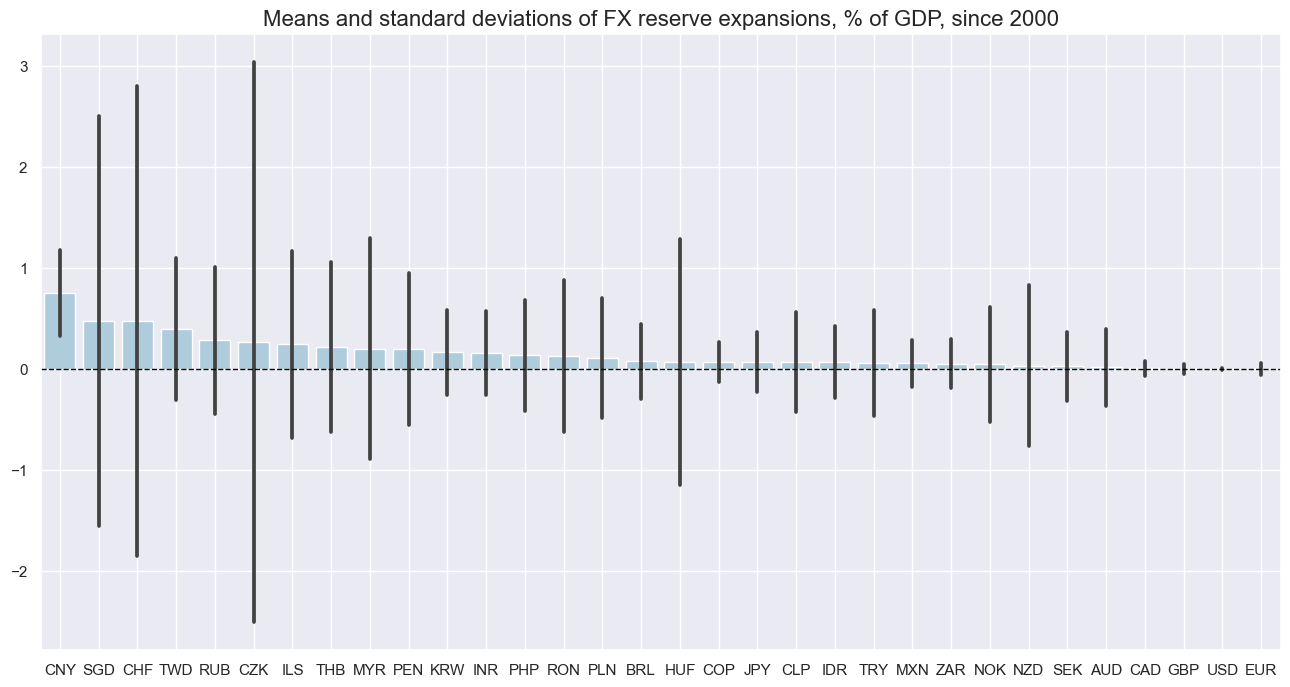

<IPython.core.display.Javascript object>

In [10]:
xcatx = ["CRESFXGDP_NSA_D1M1ML1"]
cidx = cids_exp

msp.view_ranges(
    dfd,
    xcats=xcatx,
    cids=cidx,
    sort_cids_by="mean",
    start=start_date,
    title="Means and standard deviations of FX reserve expansions, % of GDP, since 2000",
    kind="bar",
    size=(16, 8),
)

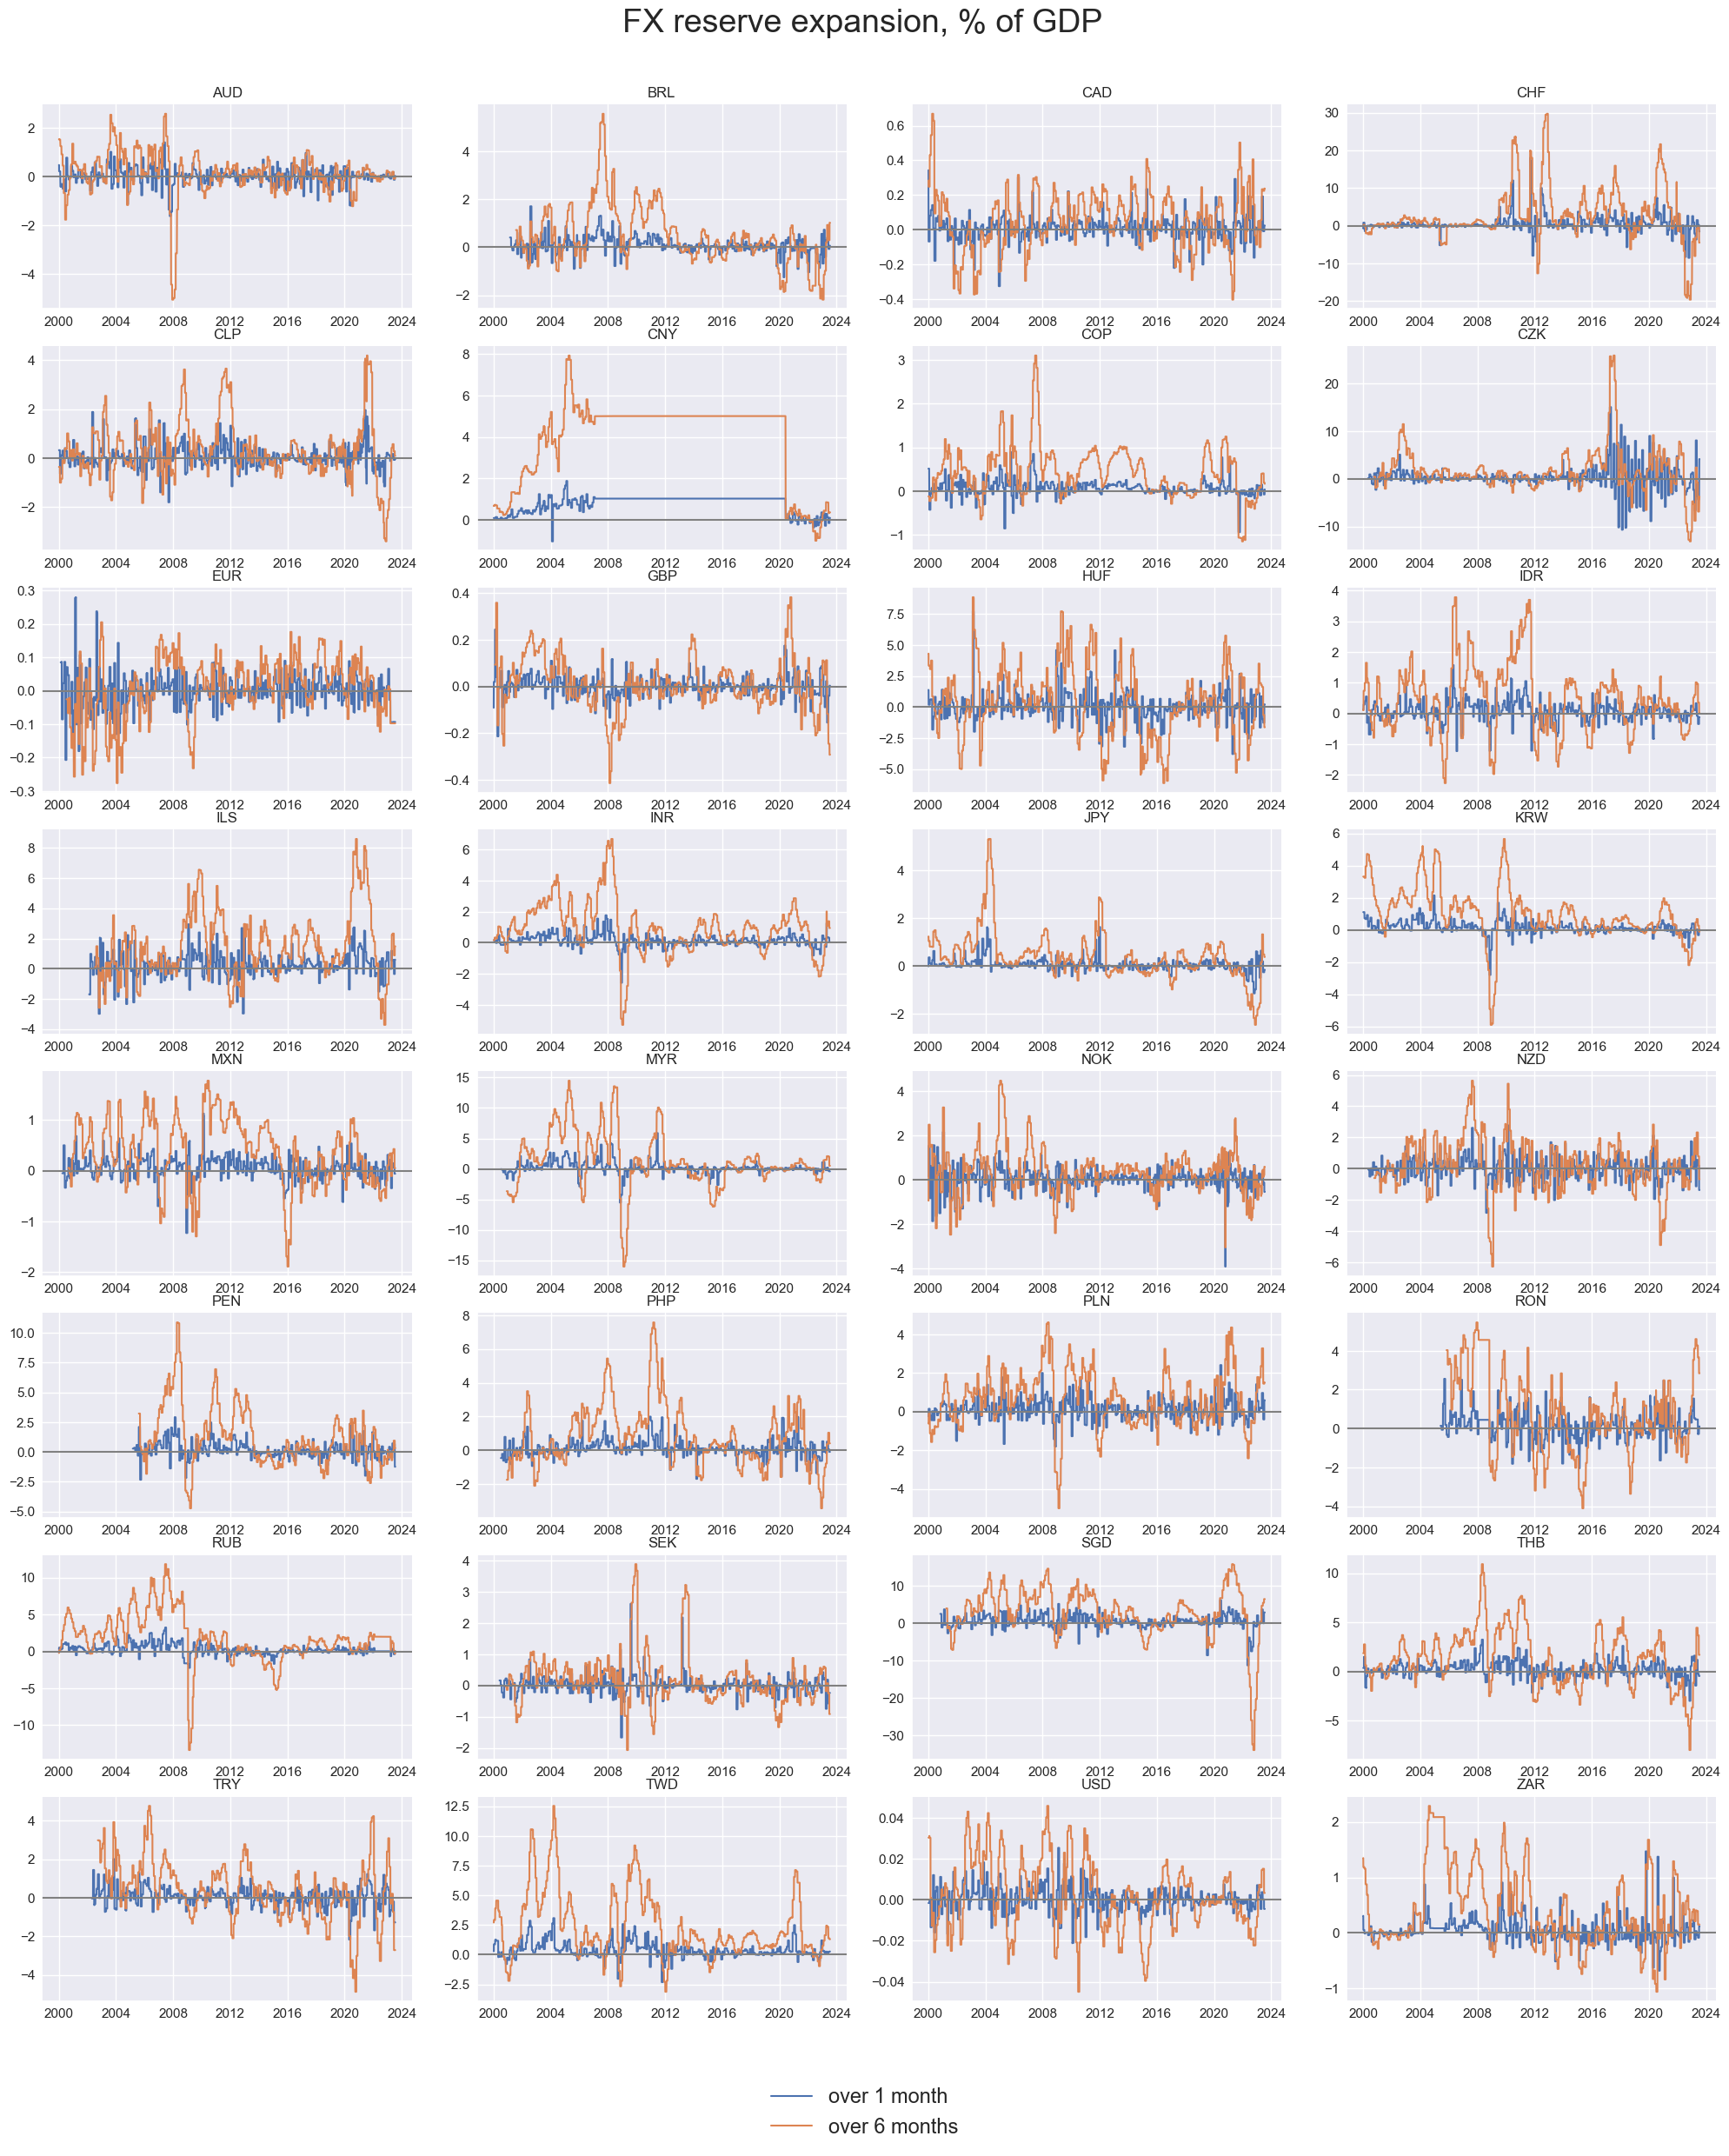

<IPython.core.display.Javascript object>

In [30]:
xcatx = ["CRESFXGDP_NSA_D1M1ML1", "CRESFXGDP_NSA_D1M1ML6"]
cidx = cids_exp

msp.view_timelines(
    dfd,
    xcats=xcatx,
    cids=cidx,
    start=start_date,
    title="FX reserve expansion, % of GDP",
    title_adj=1.03,
    title_fontsize=27,
    legend_fontsize=17,
    title_xadj=0.455,
    label_adj=0.075,
    xcat_labels=["over 1 month", "over 6 months"],
    ncol=4,
    same_y=False,
    size=(12, 7),
    aspect=1.7,
    all_xticks=True,
)

Observed monthly FX reserve expansion has been mostly positively correlated across currency areas, particularly among EM and Asian countries.

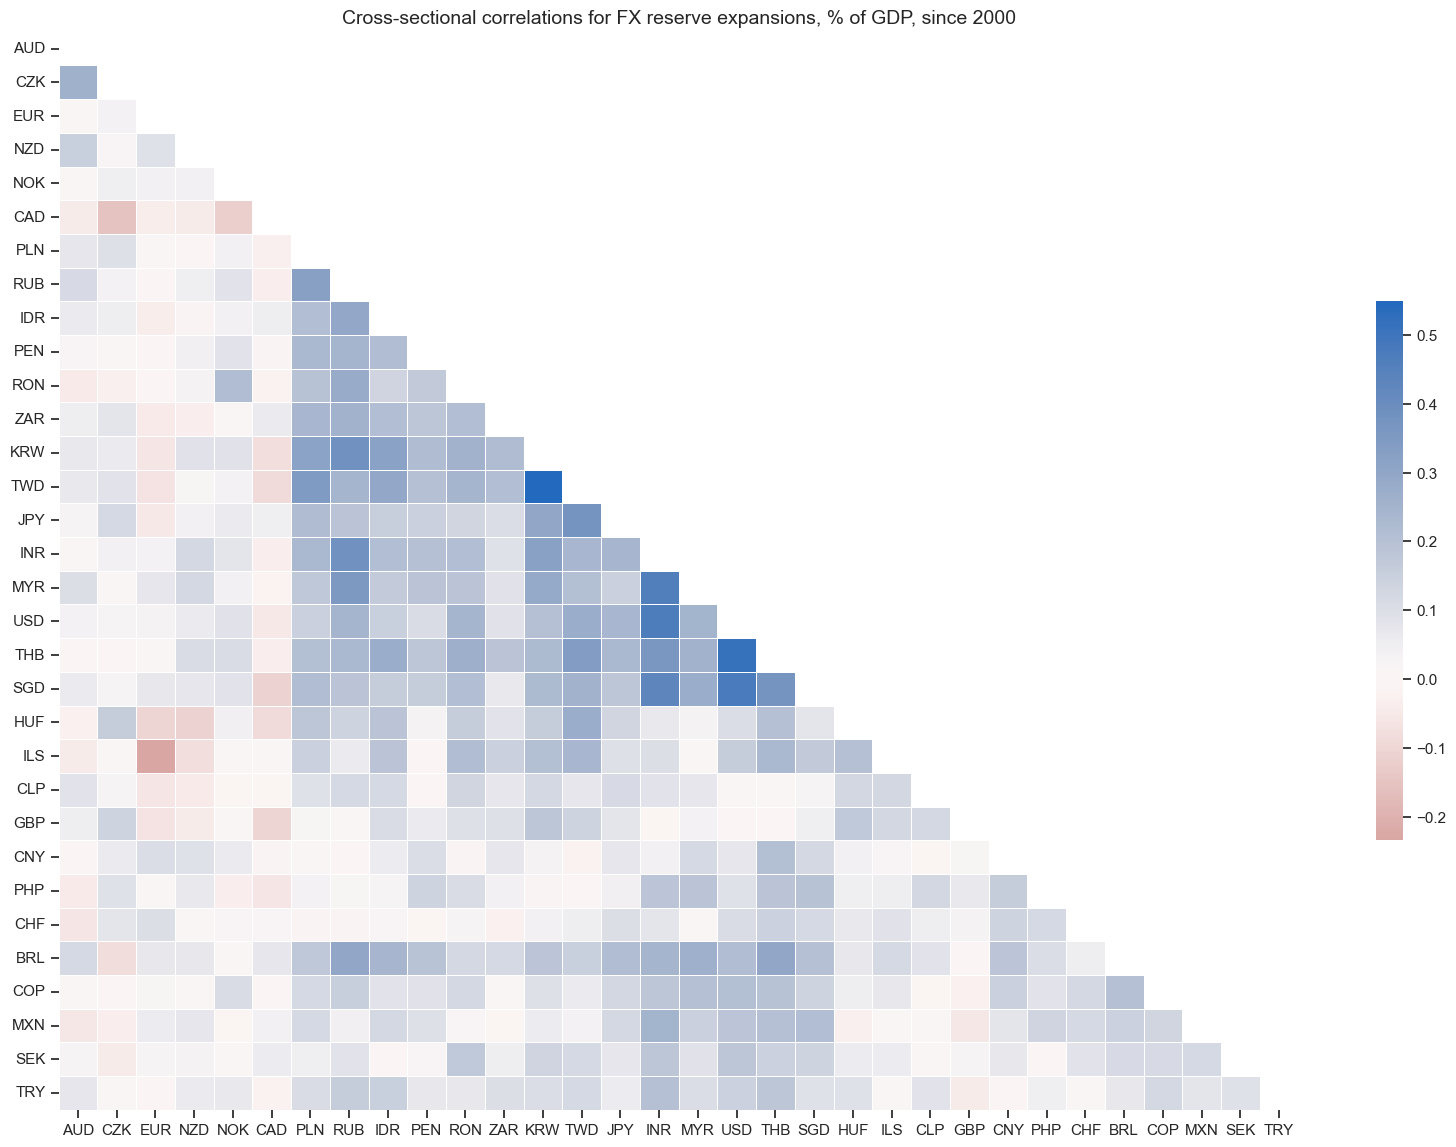

<IPython.core.display.Javascript object>

In [12]:
xcatx = "CRESFXGDP_NSA_D1M1ML1"
cidx = cids_exp

msp.correl_matrix(
    dfd,
    xcats=xcatx,
    cids=cidx,
    size=(20, 14),
    title="Cross-sectional correlations for FX reserve expansions, % of GDP, since 2000",
    cluster=True,
)

## Domestic securities purchase expansion as % of GDP

Security purchases have so far been positive across developed countries with official programs.

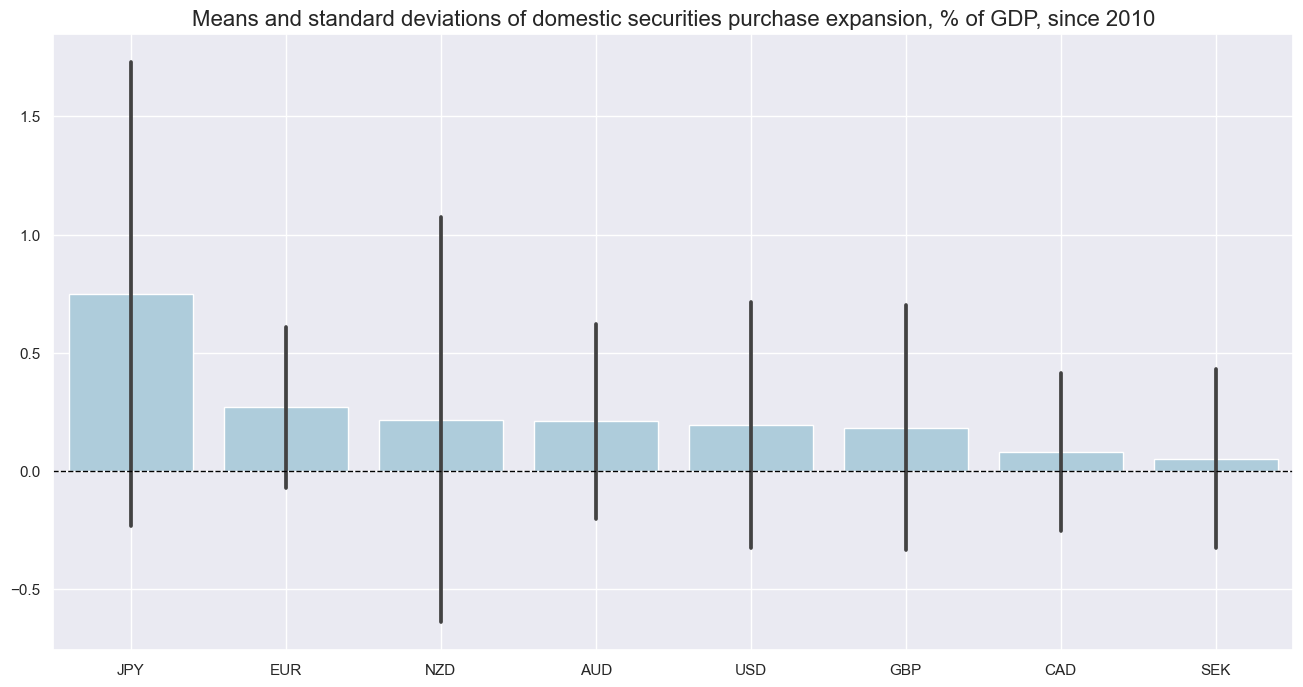

<IPython.core.display.Javascript object>

In [13]:
xcatx = ["SPACSGDP_NSA_D1M1ML1"]
cidx = cids_spacs

msp.view_ranges(
    dfd,
    xcats=xcatx,
    cids=cidx,
    sort_cids_by="mean",
    start="2010-01-01",
    title="Means and standard deviations of domestic securities purchase expansion, % of GDP, since 2010",
    kind="bar",
    size=(16, 8),
)

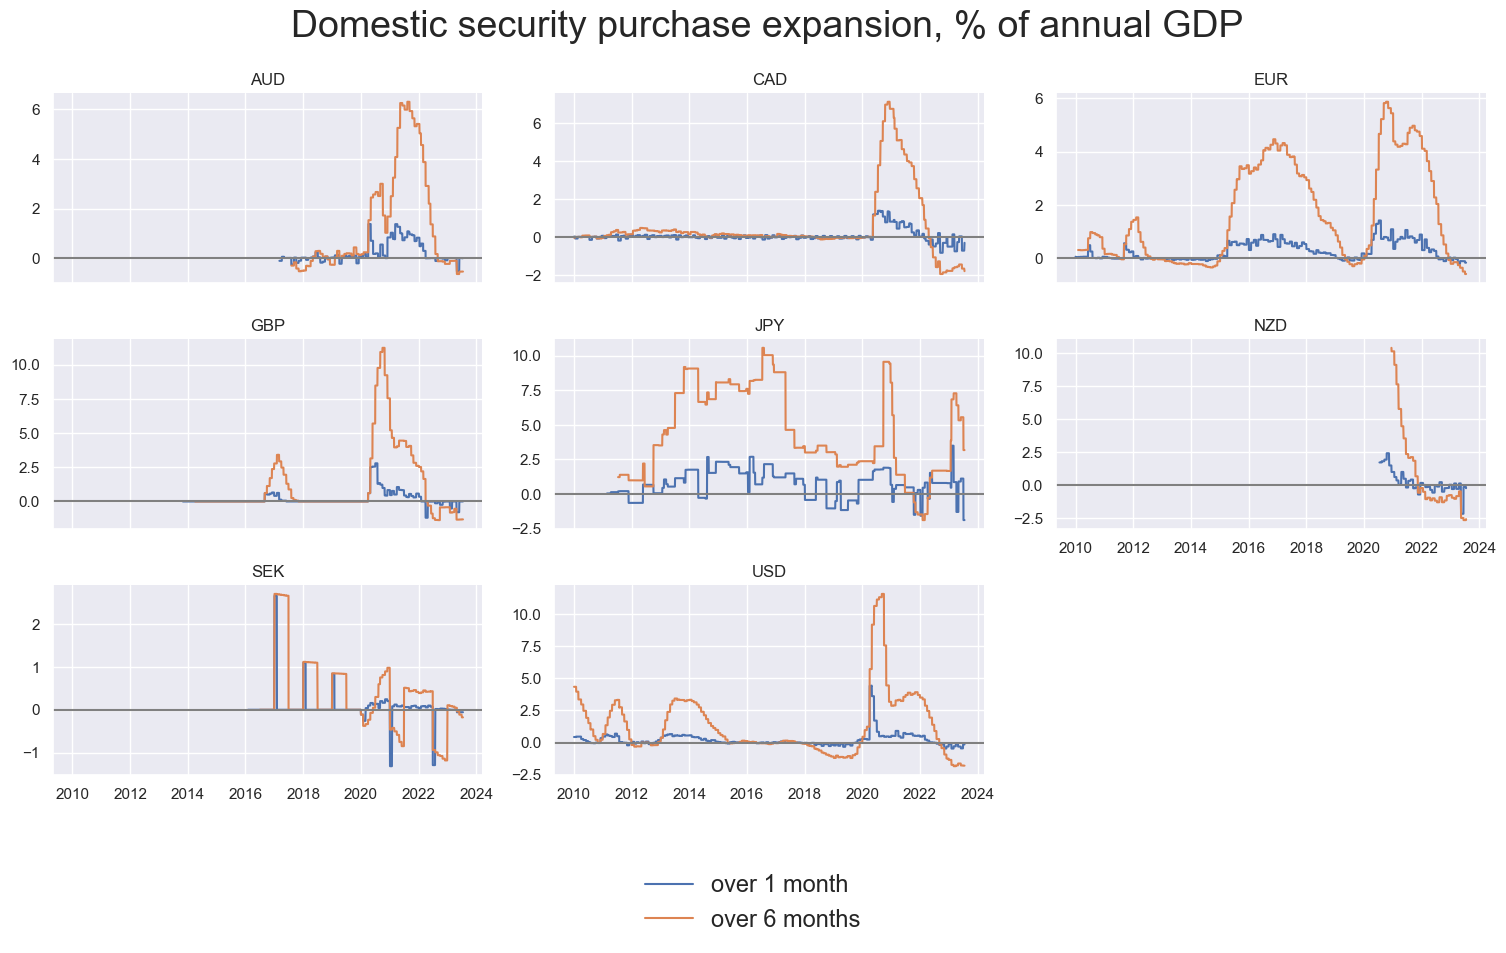

<IPython.core.display.Javascript object>

In [33]:
xcatx = ["SPACSGDP_NSA_D1M1ML1", "SPACSGDP_NSA_D1M1ML6"]
cidx = cids_spacs

msp.view_timelines(
    dfd,
    xcats=xcatx,
    cids=cidx,
    start="2010-01-01",
    title="Domestic security purchase expansion, % of annual GDP",
    title_adj=1.05,
    title_xadj=0.45,
    title_fontsize=27,
    legend_fontsize=17,
    xcat_labels=["over 1 month", "over 6 months"],
    label_adj=0.2,
    ncol=3,
    same_y=False,
    size=(12, 7),
    aspect=1.7,
    all_xticks=False,
)

## Monetary base expansion as % of GDP

Mean monetary base expansion has been positive across all countries since 2000. There have been large variations across time, in some countries clearly related to security purchase programs.

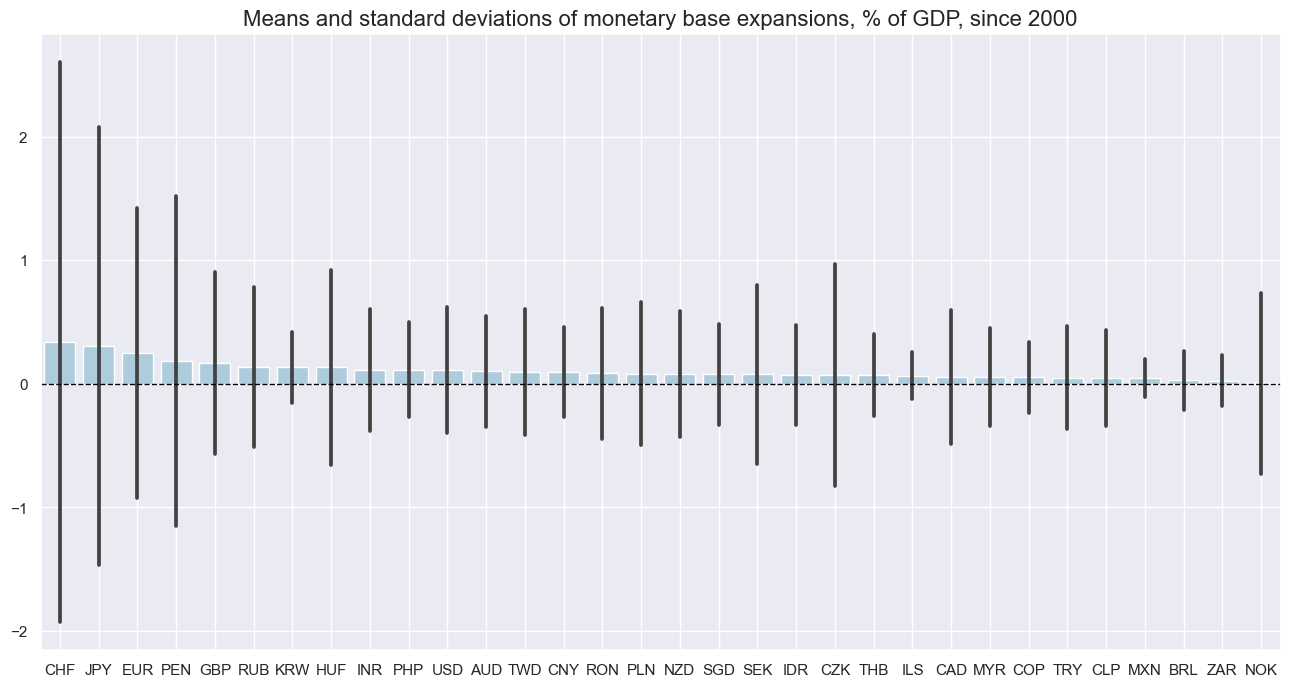

<IPython.core.display.Javascript object>

In [34]:
xcatx = ["MBASEGDP_SA_D1M1ML1"]
cidx = cids_exp

msp.view_ranges(
    dfd,
    xcats=xcatx,
    cids=cidx,
    sort_cids_by="mean",
    start=start_date,
    title="Means and standard deviations of monetary base expansions, % of GDP, since 2000",
    kind="bar",
    size=(16, 8),
)

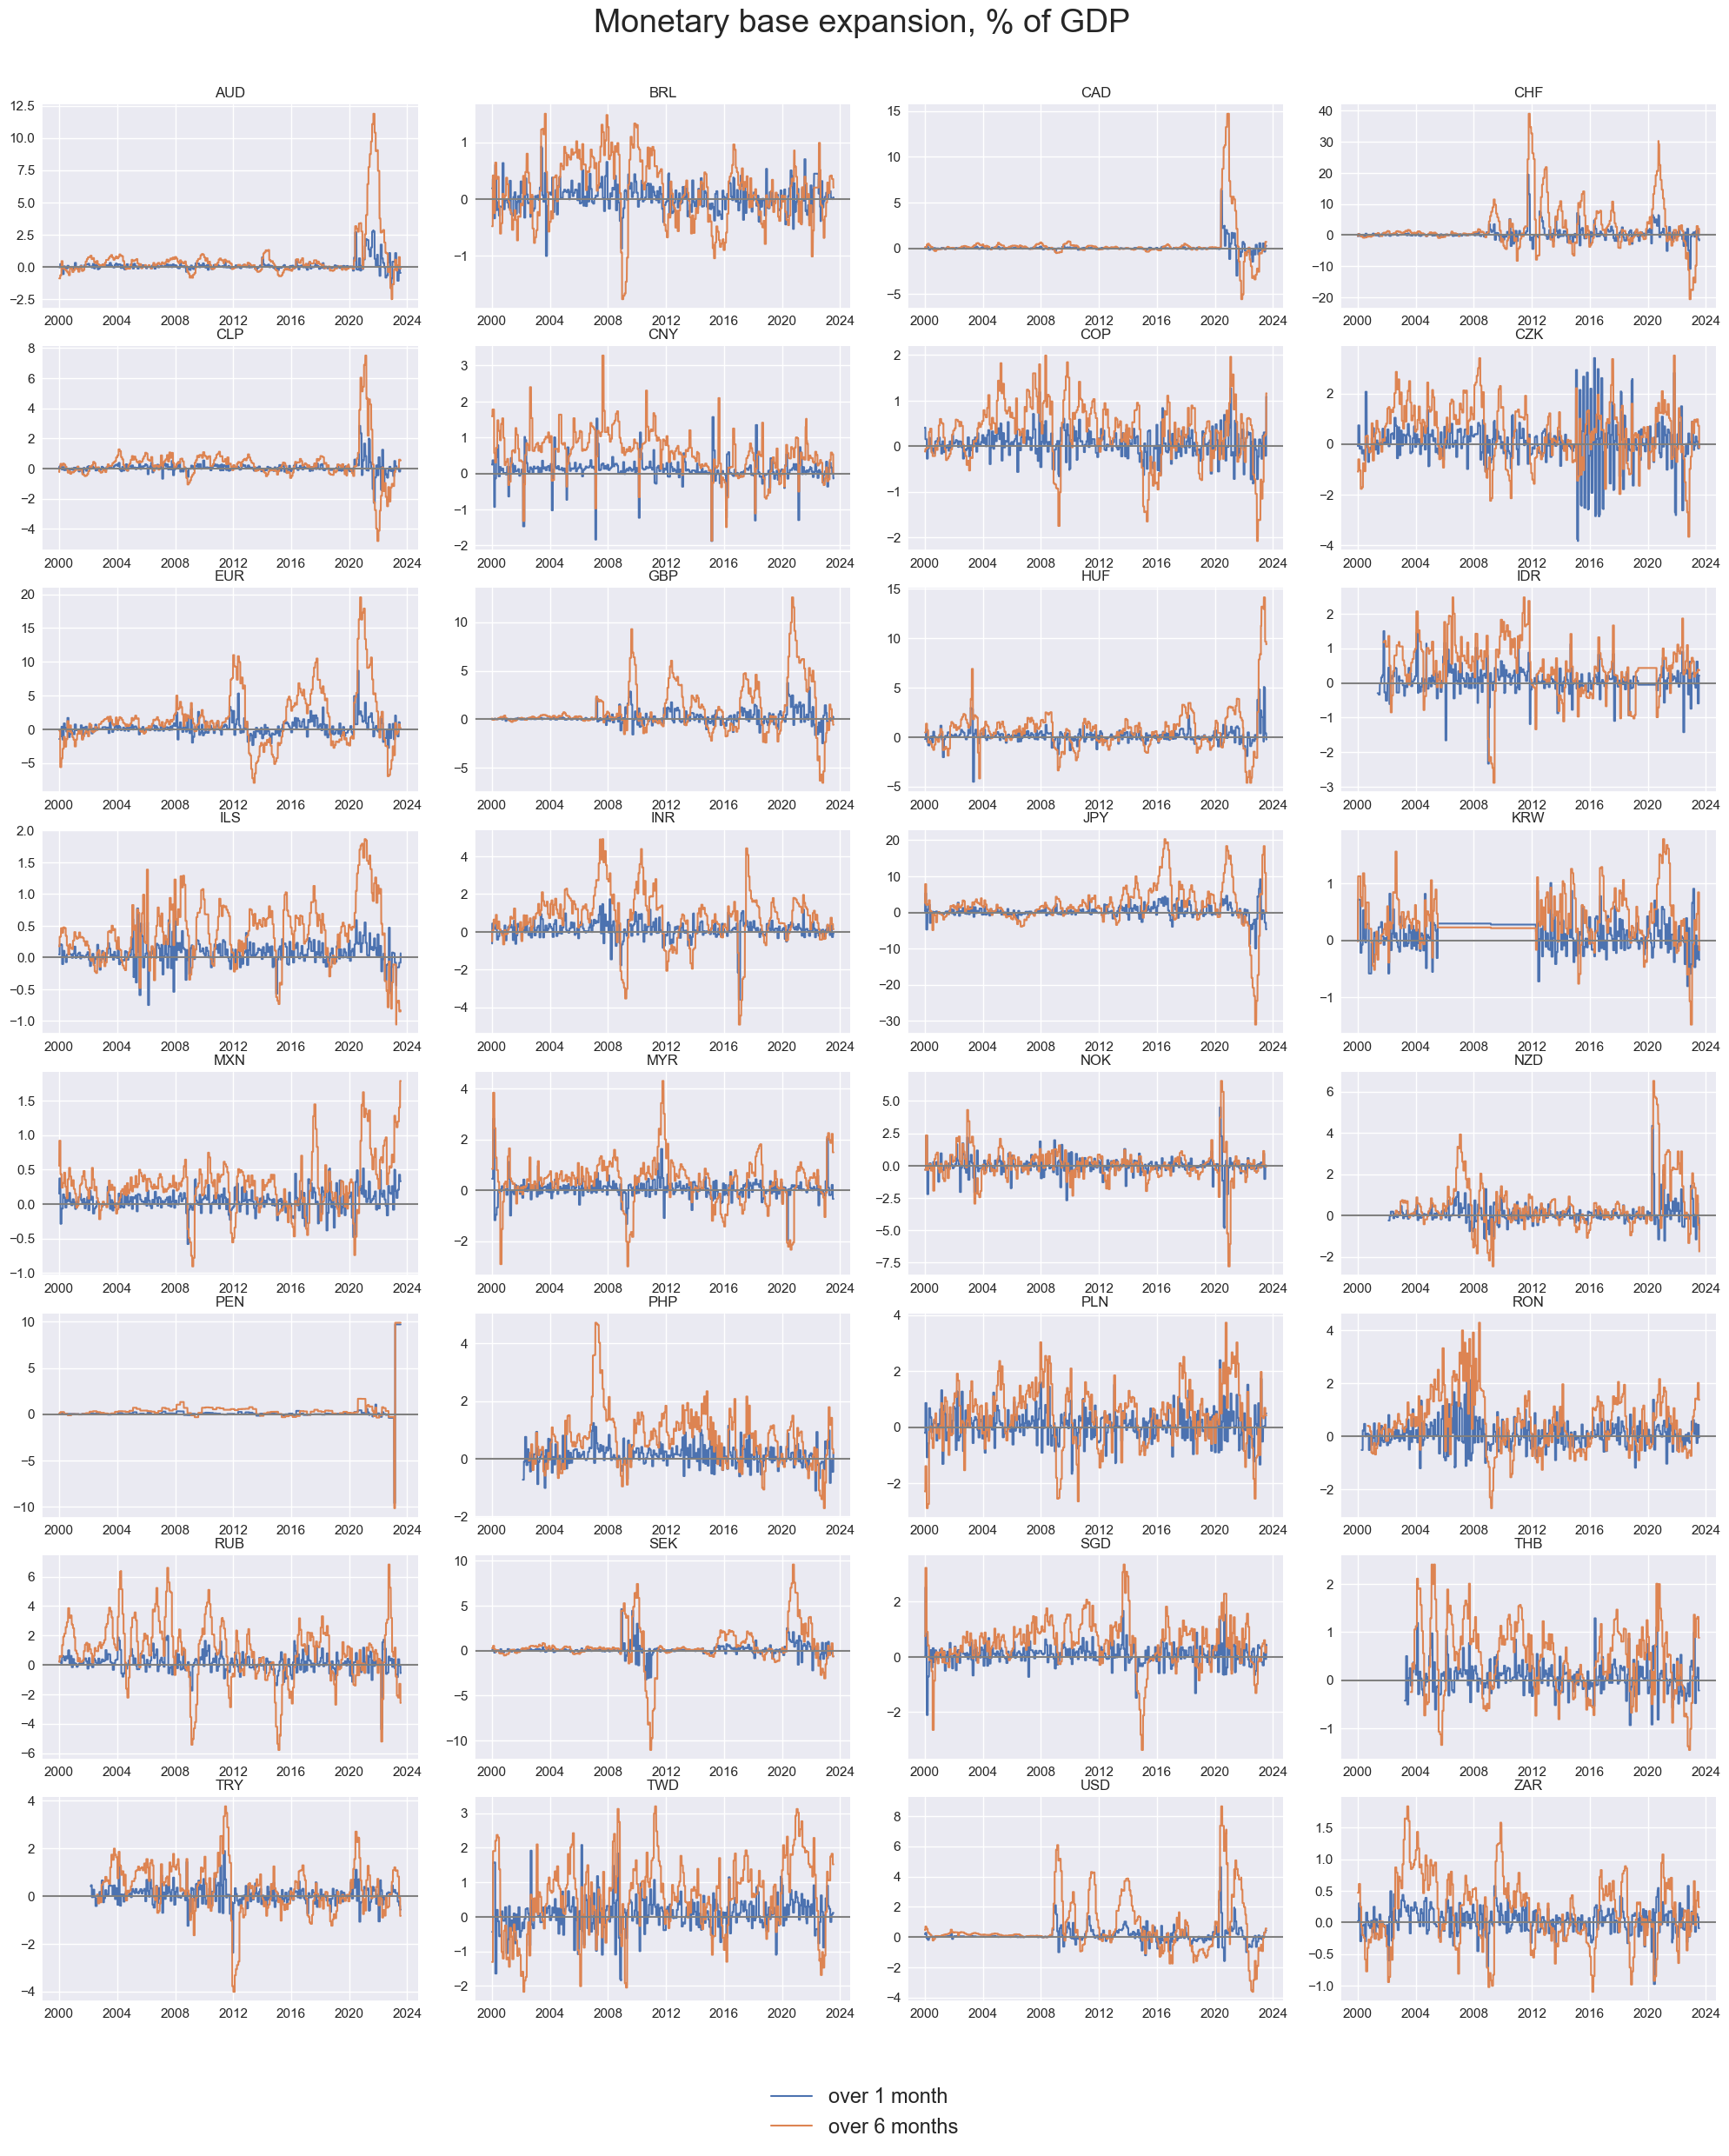

<IPython.core.display.Javascript object>

In [38]:
xcatx = ["MBASEGDP_SA_D1M1ML1", "MBASEGDP_SA_D1M1ML6"]
cidx = cids_exp

msp.view_timelines(
    dfd,
    xcats=xcatx,
    cids=cidx,
    start="2000-01-01",
    title="Monetary base expansion, % of GDP",
    title_adj=1.03,
    title_xadj=0.455,
    title_fontsize=27,
    legend_fontsize=17,
    label_adj=0.075,
    xcat_labels=["over 1 month", "over 6 months"],
    ncol=4,
    same_y=False,
    size=(12, 7),
    aspect=1.7,
    all_xticks=True,
)

Observed monetary base expansions have been mostly positively correlated across currency areas.

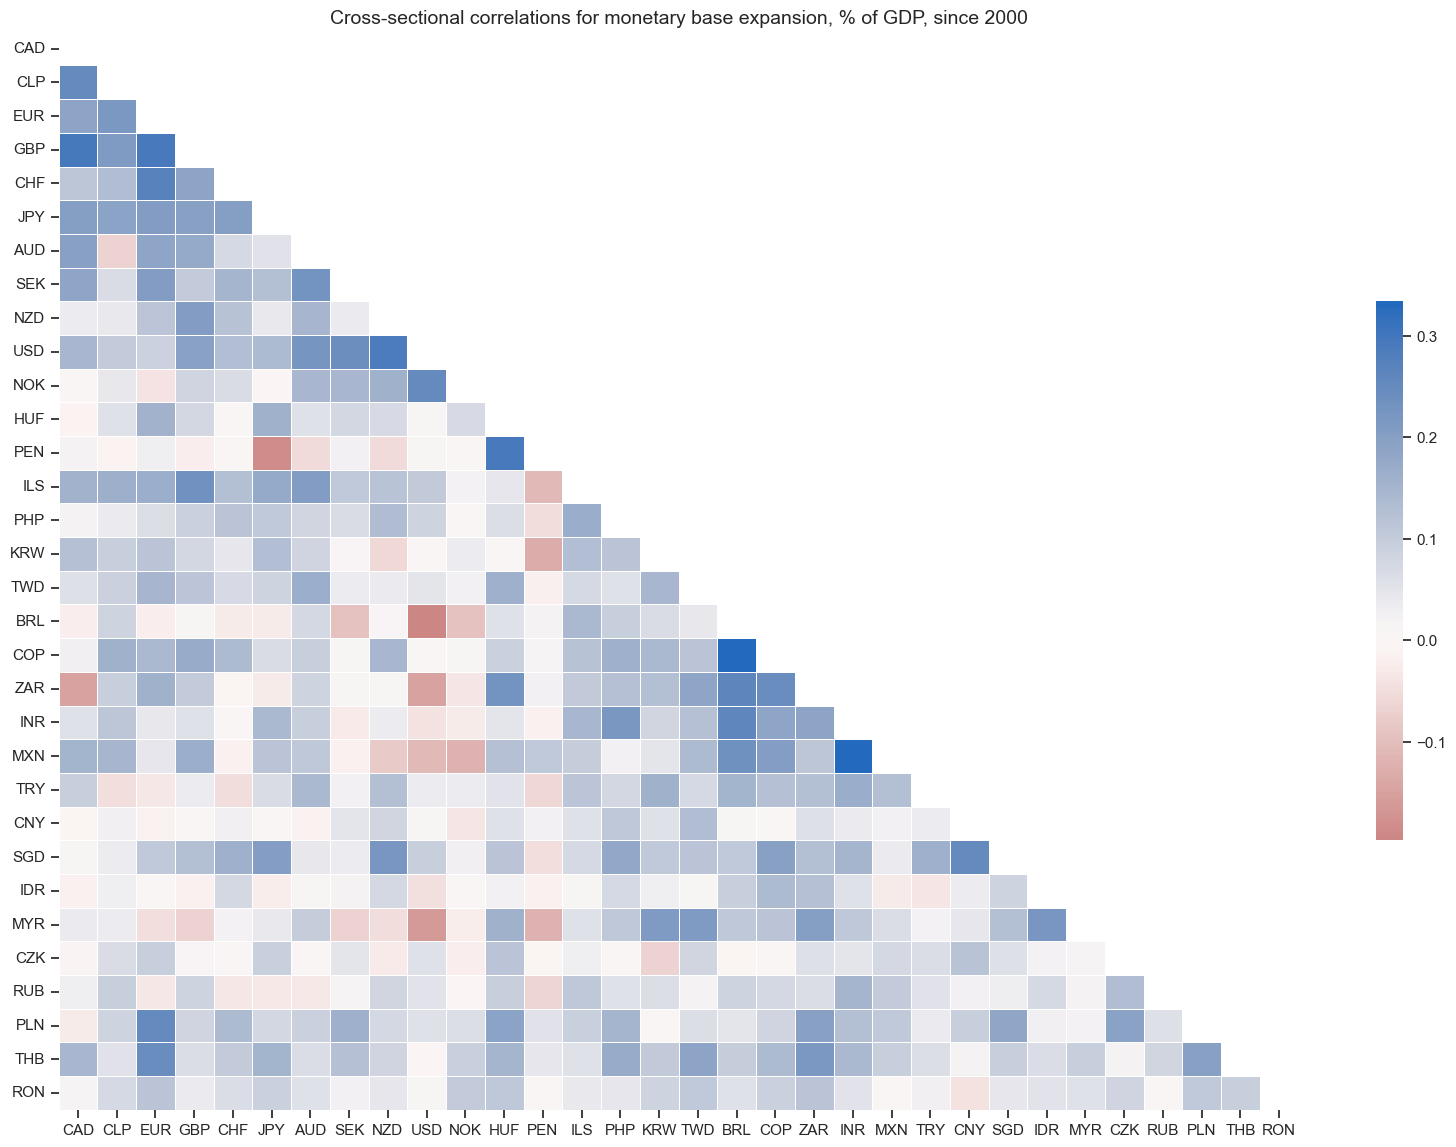

<IPython.core.display.Javascript object>

In [39]:
xcatx = "MBASEGDP_SA_D1M1ML1"
cidx = cids_exp

msp.correl_matrix(
    dfd,
    xcats=xcatx,
    cids=cidx,
    title="Cross-sectional correlations for monetary base expansion, % of GDP, since 2000",
    size=(20, 14),
    cluster=True,
)

## Intervention-driven liquidity expansion as % of GDP

The intervention-driven liquidity expansions have been positive over the long-term across all countries. The low interest-rate countries in Japan and Switzerland have experienced the largest long-term expansions, evidently related to their central banks' struggle against deflation.

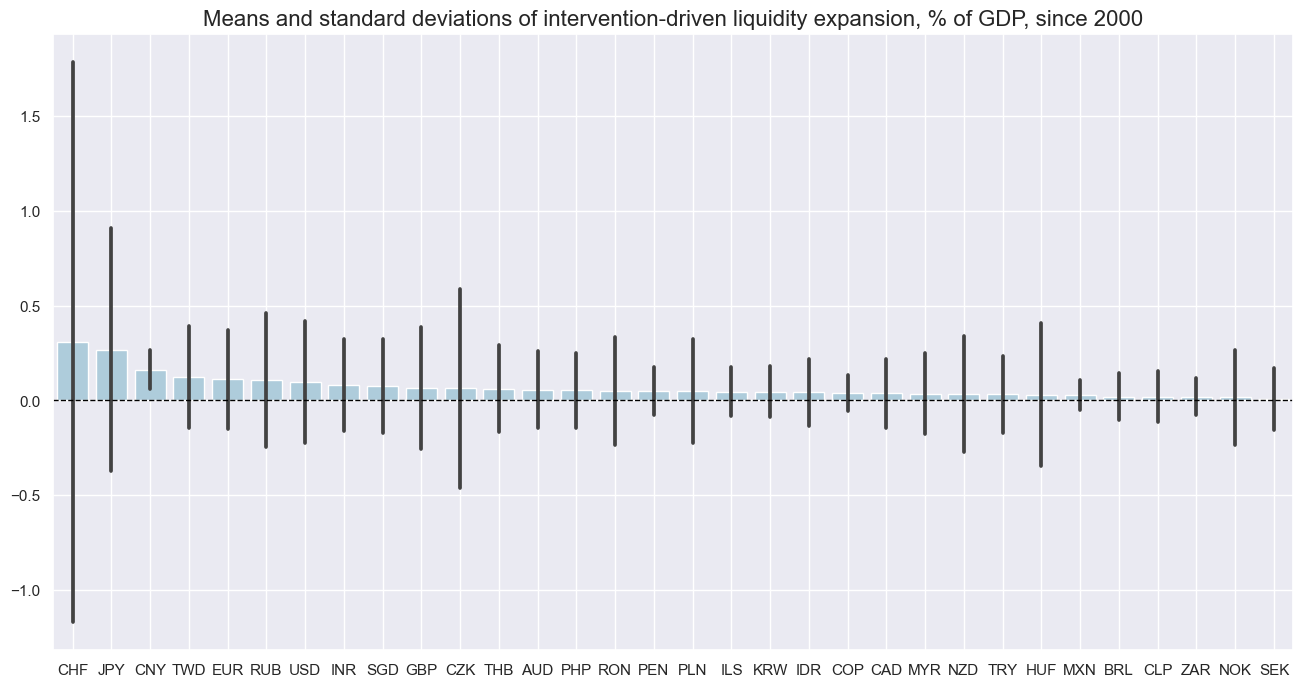

<IPython.core.display.Javascript object>

In [40]:
xcatx = ["INTLIQGDP_NSA_D1M1ML1"]
cidx = cids_exp

msp.view_ranges(
    dfd,
    xcats=xcatx,
    cids=cidx,
    sort_cids_by="mean",
    start="2000-01-01",
    title="Means and standard deviations of intervention-driven liquidity expansion, % of GDP, since 2000",
    kind="bar",
    size=(16, 8),
)

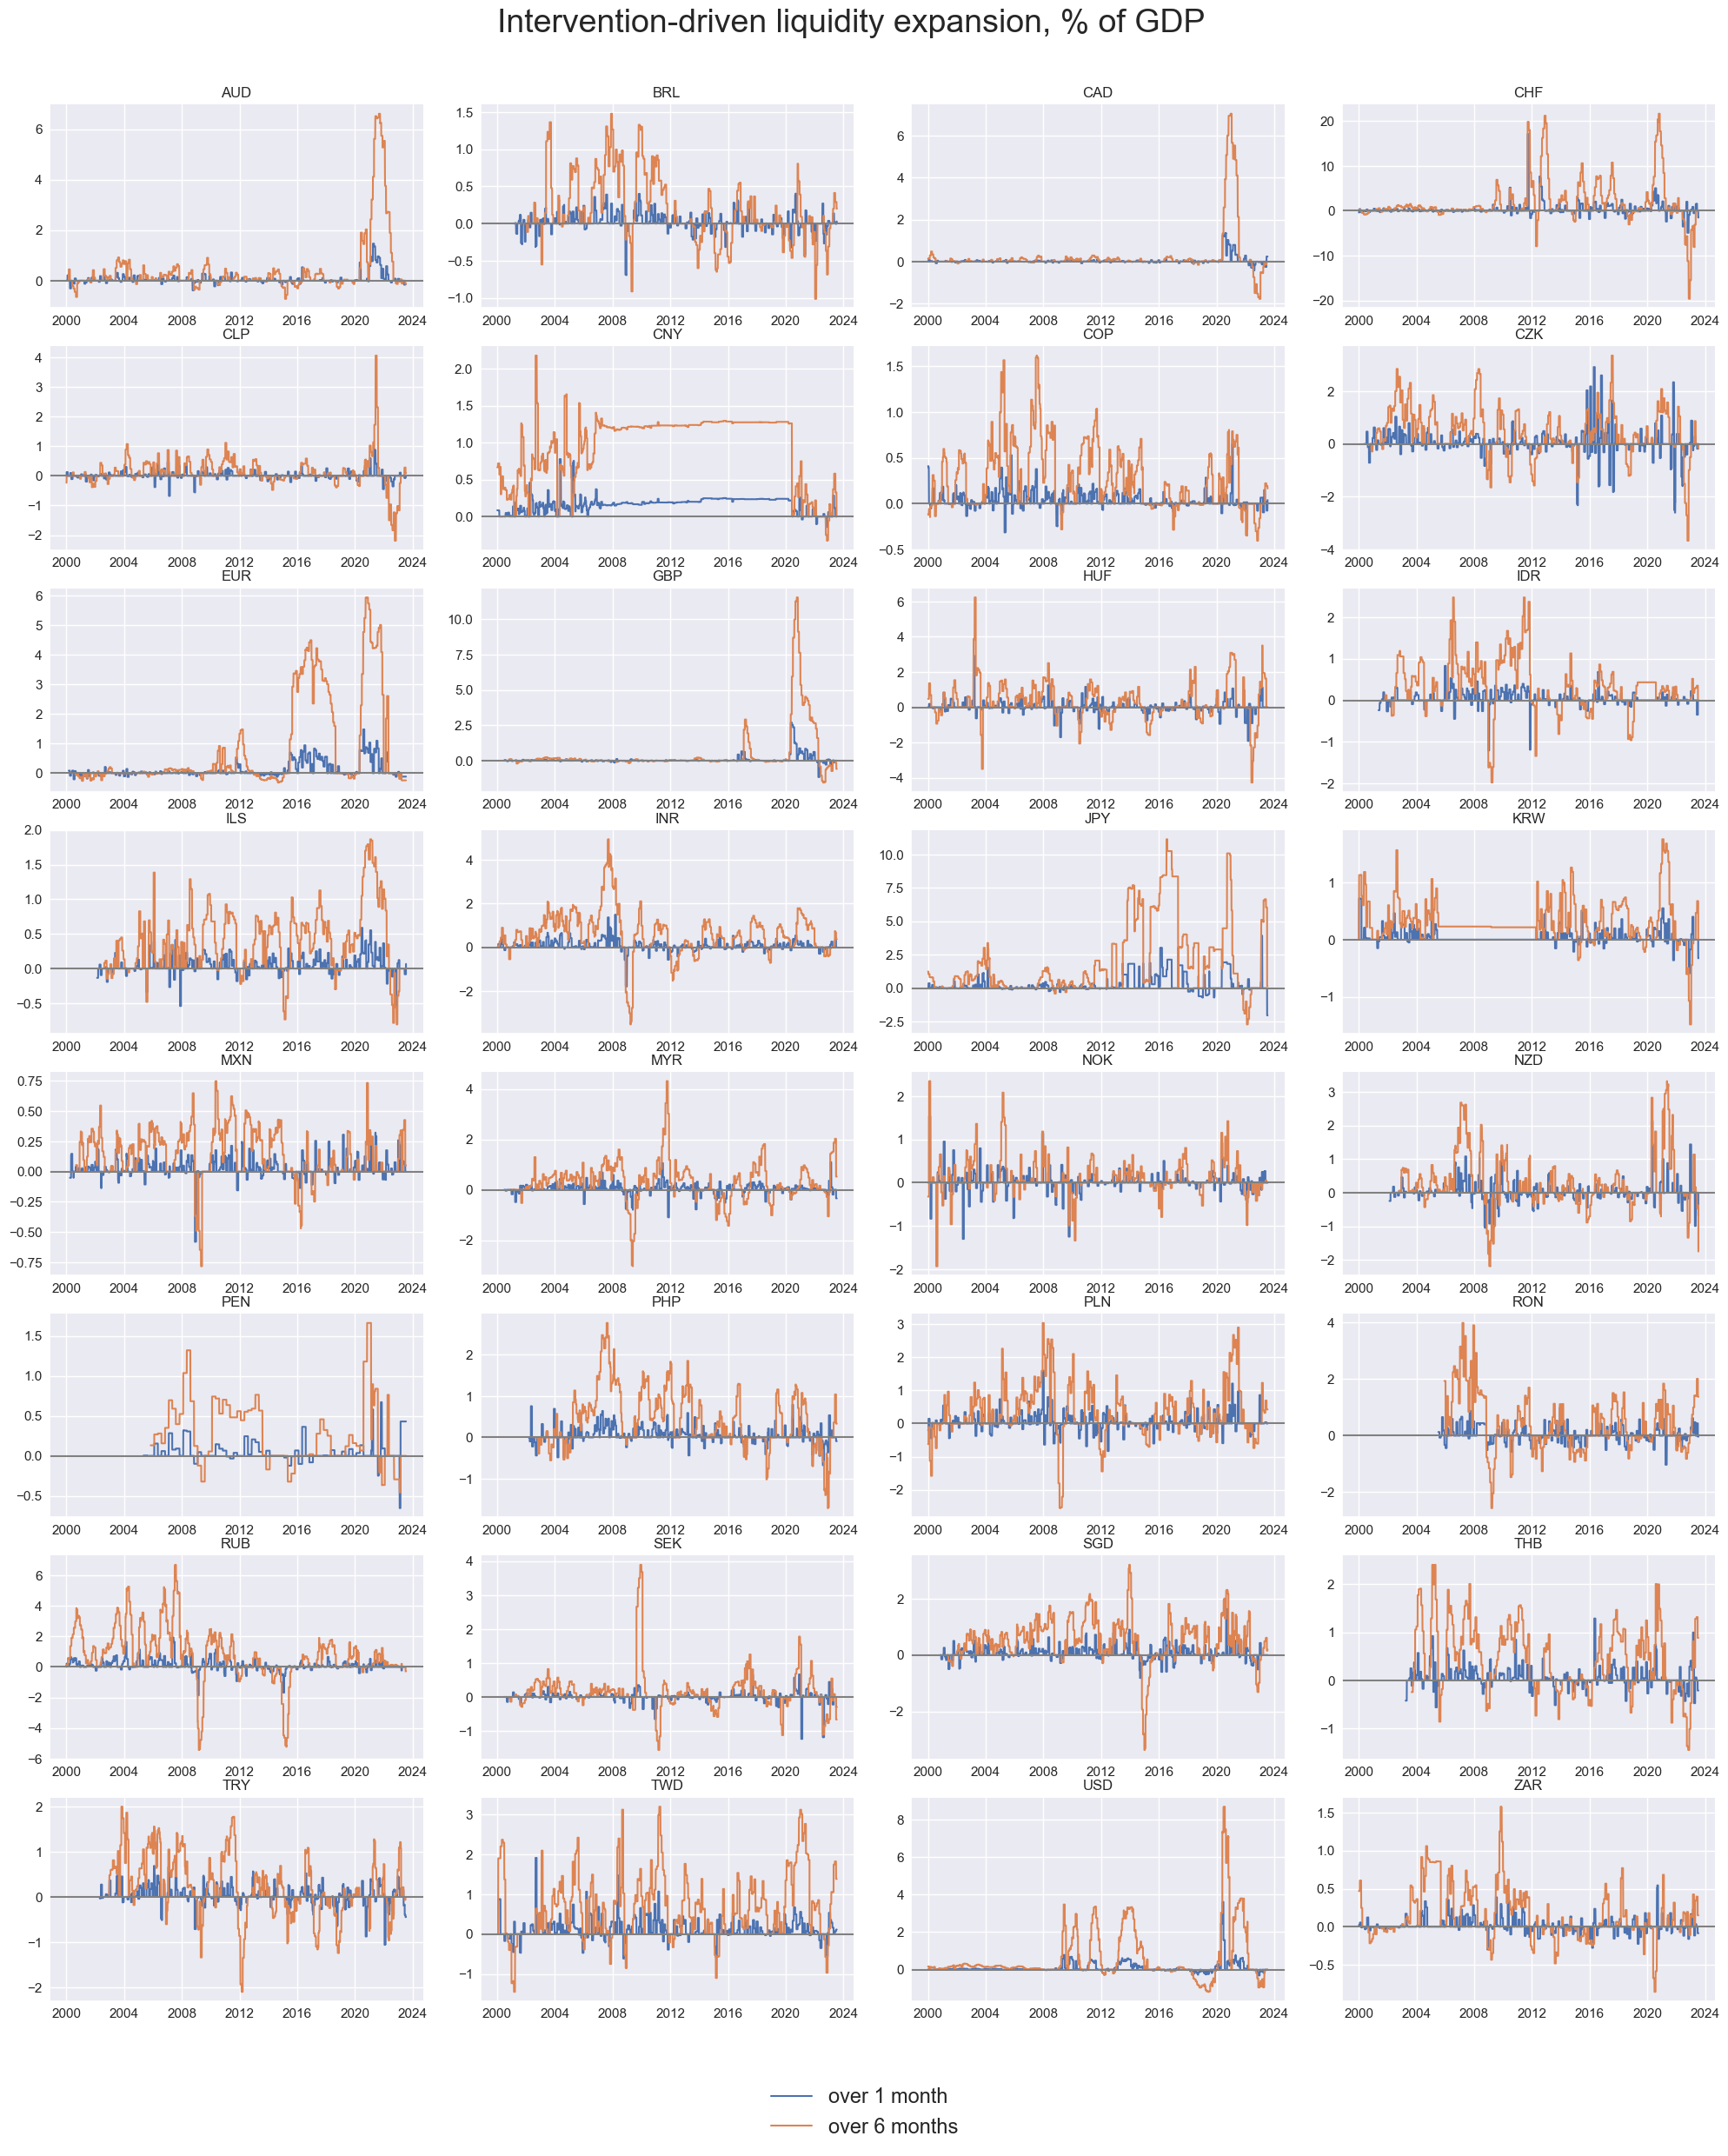

<IPython.core.display.Javascript object>

In [41]:
xcatx = ["INTLIQGDP_NSA_D1M1ML1", "INTLIQGDP_NSA_D1M1ML6"]
cidx = cids_exp

msp.view_timelines(
    dfd,
    xcats=xcatx,
    cids=cidx,
    start="2000-01-01",
    title="Intervention-driven liquidity expansion, % of GDP",
    title_adj=1.03,
    title_xadj=0.45,
    title_fontsize=27,
    legend_fontsize=17,
    label_adj=0.075,
    xcat_labels=["over 1 month", "over 6 months"],
    ncol=4,
    same_y=False,
    size=(12, 7),
    aspect=1.7,
    all_xticks=True,
)

# Importance

## Research links

"The FX intervention toolkit has continued to expand, but spot market interventions remain the most common instrument. All central banks except one intervene in spot markets, at least occasionally. More than a quarter also operate routinely in derivatives markets...Among derivatives, swaps are used most often, followed by forwards. The vast majority of central banks intervene on-shore...The predominant use of discretion (versus rules) may be the result of several factors...Discretion might be necessary whenever the central bank wishes to prevent detection. It is also the best way of maximising the surprise factor and hence market impact, although it could be calibrated so as to reduce it. The limited use of rules may also reflect difficulties in formulating simple ones based on real-time information...The survey results suggest an overwhelming preference for intervening in response to market developments. More than thirds of the central banks surveyed normally intervene after the market has moved in a certain direction, while three (of 21 EM central banks) report that they occasionally intervene pre-emptively." [Cavallino and Patel](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3497860)

"Foreign exchange intervention based on novel daily data...works well in terms of smoothing the path of exchange rates, and in stabilizing the exchange rate in countries with narrow band regimes. Moving the level of the exchange rate in flexible regimes requires that some conditions are met, including the use of large volumes and that intervention is made public and supported via communication." [Fratzscher et al](https://www.aeaweb.org/articles?id=10.1257/mac.20150317)

"Most official forex interventions in recent years have aimed to stem volatility, rather than to achieve a particular exchange rate. The majority view was that exchange rate intervention needs to be consistent with the monetary policy stance. Persistent, one-sided intervention, associated with a sharp expansion of central bank and commercial bank balance sheets, creates risks for the economy." [BIS](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2420030)

"(There is) empirical evidence of a reserve-induced transmission channel of quantitative easing to long-term interest rates. Reserve-induced effects are independent of the assets purchased and run through the impact of reserve expansions on bank balance sheets and the resulting bank portfolio rebalancing." [Christensen and Krogstrup](https://academic.oup.com/ej/article-abstract/129/617/249/5250963?login=false)

"The European Central Bank’s bond purchases...caused significant mispricing between German and Italian government bonds and their respective futures contracts. We document three channels through which the central bank’s bond purchases led to this mispricing: the deterioration of bond market liquidity, the increased bond 'specialness' on the repurchase agreement market, and the higher cost of carry. The mispricing...is the result of two contemporaneous forces: the increased in trading frictions caused by Quantitative Easing, and regulatory capital constraints that imply non-negative required returns on riskless trades." [Pelizzon et al](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3239407)

## Empirical clues

FX reserves and monetary base expansions have posted a positive correlation across the emerging and developed world. This suggests that, at least in part, FX interventions have been unsterilized, causing direct liquidity effects on local markets.

In [20]:
dfb = dfd[dfd["xcat"].isin(["FXTARGETED_NSA", "FXUNTRADABLE_NSA"])].loc[
    :, ["cid", "xcat", "real_date", "value"]
]
dfba = (
    dfb.groupby(["cid", "real_date"])
    .aggregate(value=pd.NamedAgg(column="value", aggfunc="max"))
    .reset_index()
)
dfba["xcat"] = "FXBLACK"
fxblack = msp.make_blacklist(dfba, "FXBLACK")
fxblack

{'BRL': (Timestamp('2012-12-03 00:00:00'), Timestamp('2013-09-30 00:00:00')),
 'CHF': (Timestamp('2011-05-02 00:00:00'), Timestamp('2016-06-30 00:00:00')),
 'CNY': (Timestamp('2000-01-03 00:00:00'), Timestamp('2023-07-18 00:00:00')),
 'CZK': (Timestamp('2014-01-01 00:00:00'), Timestamp('2017-07-31 00:00:00')),
 'ILS': (Timestamp('2000-01-03 00:00:00'), Timestamp('2005-12-30 00:00:00')),
 'INR': (Timestamp('2000-01-03 00:00:00'), Timestamp('2004-12-31 00:00:00')),
 'MYR_1': (Timestamp('2000-01-03 00:00:00'), Timestamp('2007-11-30 00:00:00')),
 'MYR_2': (Timestamp('2018-07-02 00:00:00'), Timestamp('2023-07-18 00:00:00')),
 'PEN': (Timestamp('2021-07-01 00:00:00'), Timestamp('2021-07-30 00:00:00')),
 'RON': (Timestamp('2000-01-03 00:00:00'), Timestamp('2005-11-30 00:00:00')),
 'RUB_1': (Timestamp('2000-01-03 00:00:00'), Timestamp('2005-11-30 00:00:00')),
 'RUB_2': (Timestamp('2022-02-01 00:00:00'), Timestamp('2023-07-18 00:00:00')),
 'SGD': (Timestamp('2000-01-03 00:00:00'), Timestamp('20

<IPython.core.display.Javascript object>

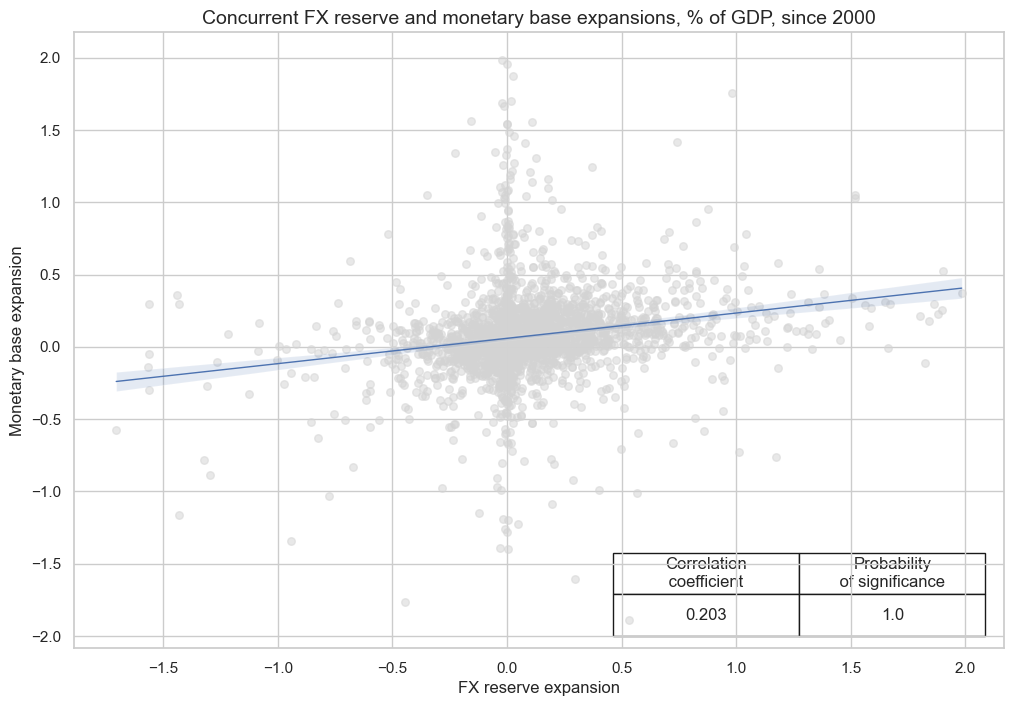

<IPython.core.display.Javascript object>

In [21]:
xcatx = ["CRESFXGDP_NSA_D1M1ML1", "MBASEGDP_SA_D1M1ML1"]
cidx = cids_exp

cr = msp.CategoryRelations(
    dfd,
    xcats=xcatx,
    cids=cidx,
    blacklist=fxblack,
    freq="Q",
    lag=0,
    xcat_aggs=["mean", "mean"],
    xcat_trims=[2, 2],
    start="2000-01-01",
    years=None,
)

cr.reg_scatter(
    coef_box="lower right",
    title="Concurrent FX reserve and monetary base expansions, % of GDP, since 2000",
    xlab="FX reserve expansion",
    ylab="Monetary base expansion",
)

There has also been a clear and positive correlation between real exchange rate strength and subsequent FX interventions. Stronger currencies tend to trigger more FX interventions.

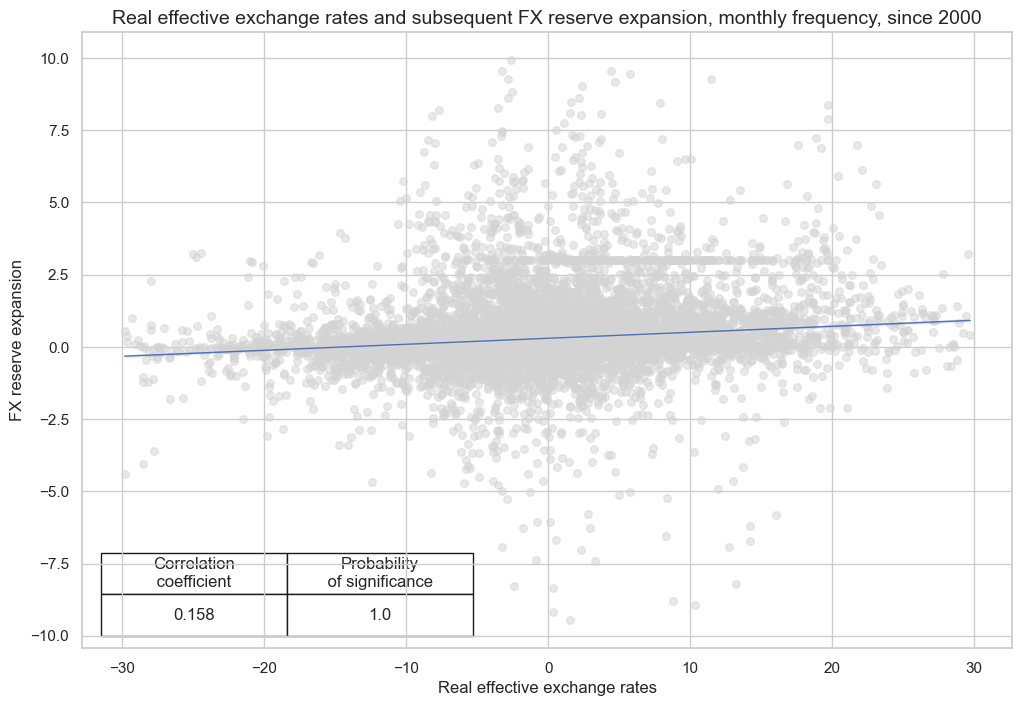

<IPython.core.display.Javascript object>

In [22]:
xcatx = ["REER_NSA_P1M60ML1", "CRESFXGDP_NSA_D1M1ML3"]
cidx = cids_exp

cr = msp.CategoryRelations(
    dfd,
    xcats=xcatx,
    cids=cidx,  # blacklist=black,
    freq="M",
    lag=1,
    xcat_aggs=["last", "mean"],
    xcat_trims=[30, 10],
    start="2000-01-01",
    years=None,
)

cr.reg_scatter(
    coef_box="lower left",
    reg_robust=True,
    title="Real effective exchange rates and subsequent FX reserve expansion, monthly frequency, since 2000",
    xlab="Real effective exchange rates",
    ylab="FX reserve expansion",
)

Historically, there has been a slight negative correlation between reported base money expansion and subsequent FX forward returns. Plausibly, the information value of liquidity creation trends is contingent on both stable market and economic conditions between the latest observed period and the current date.

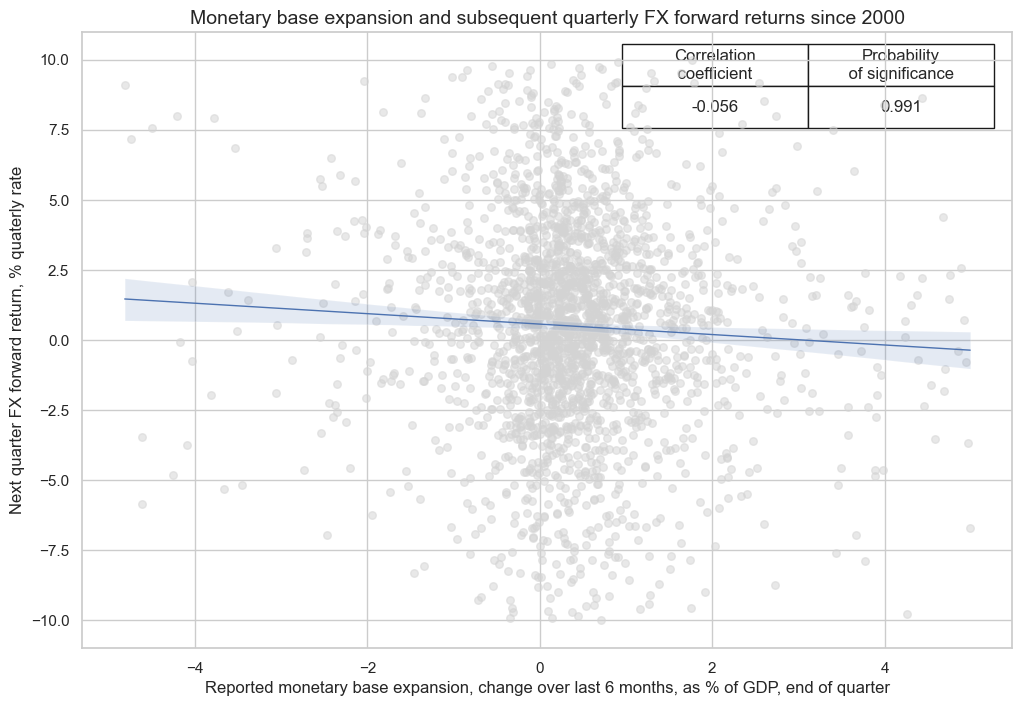

<IPython.core.display.Javascript object>

In [42]:
xcatx = ["MBASEGDP_SA_D1M1ML6", "FXXR_NSA"]
cidx = list(set(cids_exp) - set(["USD"]))

cr = msp.CategoryRelations(
    dfd,
    xcats=xcatx,
    cids=cidx,
    blacklist=fxblack,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    # xcat1_chg="diff",
    xcat_trims=[5, 10],
    start="2000-01-01",
    years=None,
)

cr.reg_scatter(
    title="Monetary base expansion and subsequent quarterly FX forward returns since 2000",
    labels=False,
    coef_box="upper right",
    xlab="Reported monetary base expansion, change over last 6 months, as % of GDP, end of quarter",
    ylab="Next quarter FX forward return, % quaterly rate",
)

Similarly, reported intervention liquidity has been slightly negatively related to subsequent FX forward returns. Yet the metric would plausibly be a more accurate predictor of subsequent returns if it was adjusted for changes in market conditions between the latest observed period and the current date.

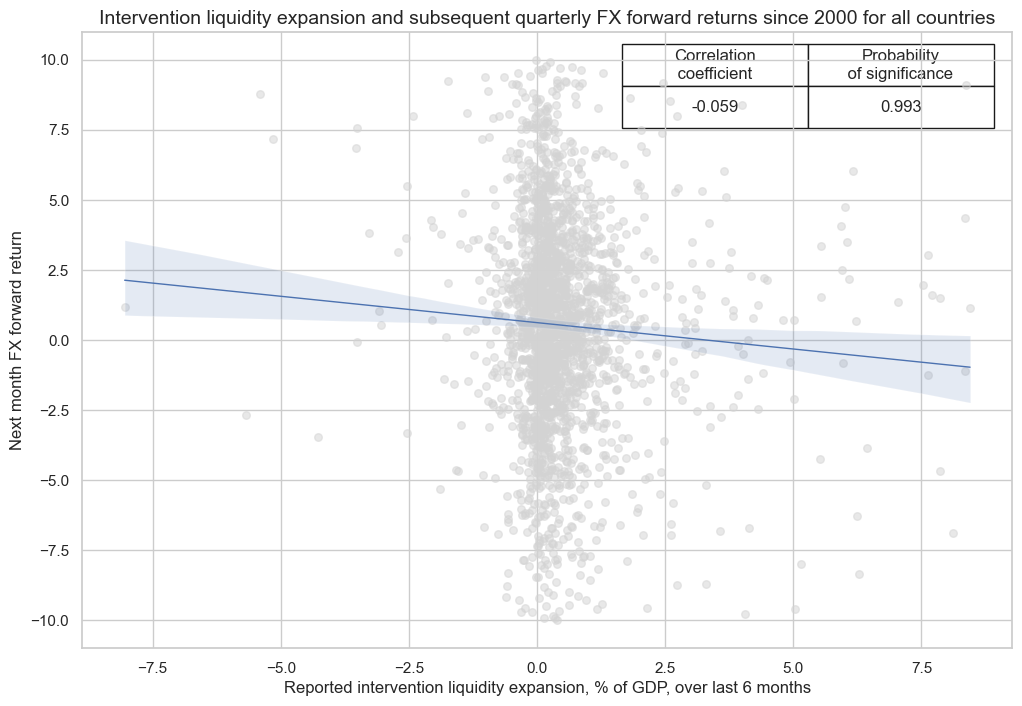

<IPython.core.display.Javascript object>

In [43]:
dfdx = dfd[~((dfd["xcat"] == "INTLIQGDP_NSA_D1M1ML6") & (abs(dfd["value"]) < 0.00001))]
xcatx = ["INTLIQGDP_NSA_D1M1ML6", "FXXR_NSA"]
cidx = list(set(cids_exp) - set(["USD"]))

cr = msp.CategoryRelations(
    dfdx,
    xcats=xcatx,
    cids=cidx,
    blacklist=fxblack,
    freq="Q",
    lag=1,
    xcat_trims=[10, 10],
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    years=None,
)

cr.reg_scatter(
    title="Intervention liquidity expansion and subsequent quarterly FX forward returns since 2000 for all countries",
    labels=False,
    coef_box="upper right",
    xlab="Reported intervention liquidity expansion, % of GDP, over last 6 months",
    ylab="Next month FX forward return",
)

However, the relation between intervention liquidity and subsequent equity returns has been positive.

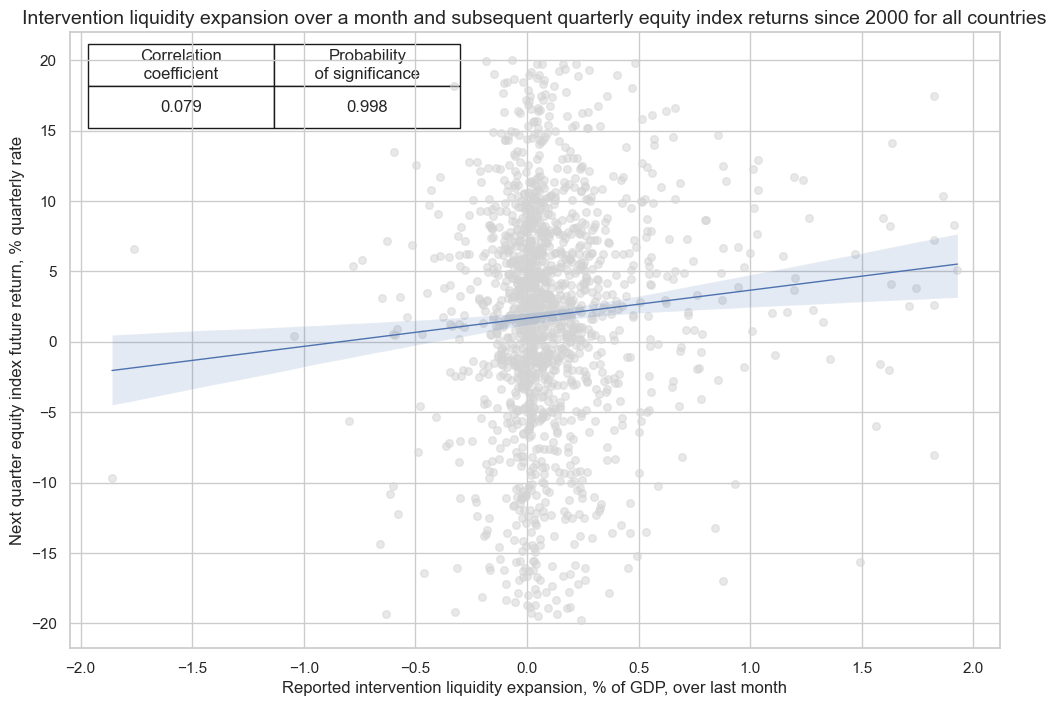

<IPython.core.display.Javascript object>

In [44]:
dfdx = dfd[~((dfd["xcat"] == "INTLIQGDP_NSA_D1M1ML1") & (abs(dfd["value"]) < 0.00001))]
xcatx = ["INTLIQGDP_NSA_D1M1ML1", "EQXR_NSA"]
cidx = list(
    set(cids_exp)
    - set(
        [
            "CLP",
            "COP",
            "CZK",
            "HUF",
            "IDR",
            "ILS",
            "NOK",
            "NZD",
            "PEN",
            "PHP",
            "RON",
            "RUB",
        ]
    )
)

cr = msp.CategoryRelations(
    dfdx,
    xcats=xcatx,
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_trims=[2, 20],
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    years=None,
)

cr.reg_scatter(
    title="Intervention liquidity expansion over a month and subsequent quarterly equity index returns since 2000 for all countries",
    labels=False,
    coef_box="upper left",
    xlab="Reported intervention liquidity expansion, % of GDP, over last month",
    ylab="Next quarter equity index future return, % quarterly rate",
)

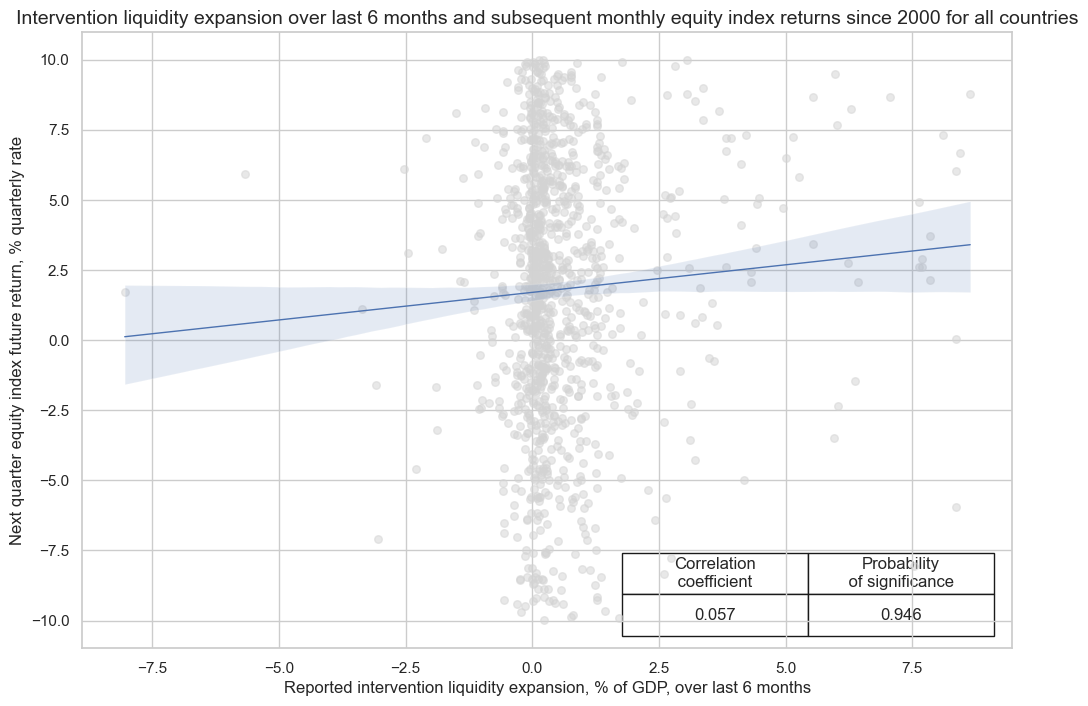

<IPython.core.display.Javascript object>

In [45]:
dfdx = dfd[~((dfd["xcat"] == "INTLIQGDP_NSA_D1M1ML6") & (abs(dfd["value"]) < 0.00001))]
xcatx = ["INTLIQGDP_NSA_D1M1ML6", "EQXR_NSA"]
cidx = list(
    set(cids_exp)
    - set(
        [
            "CLP",
            "COP",
            "CZK",
            "HUF",
            "IDR",
            "ILS",
            "NOK",
            "NZD",
            "PEN",
            "PHP",
            "RON",
            "RUB",
        ]
    )
)

cr = msp.CategoryRelations(
    dfdx,
    xcats=xcatx,
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_trims=[10, 10],
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    years=None,
)

cr.reg_scatter(
    title="Intervention liquidity expansion over last 6 months and subsequent monthly equity index returns since 2000 for all countries",
    labels=False,
    coef_box="lower right",
    xlab="Reported intervention liquidity expansion, % of GDP, over last 6 months",
    ylab="Next quarter equity index future return, % quarterly rate",
)

Interestingly, there has been some evidence of modest negative correlation between reported intervention liquidity expansion and subsequent duration returns.

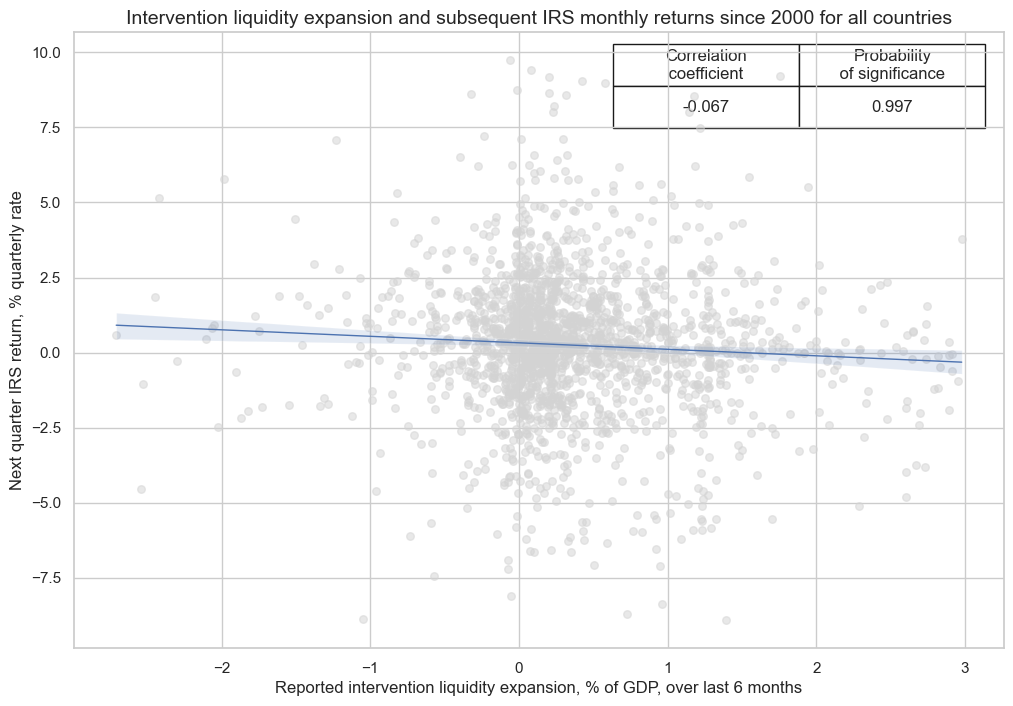

<IPython.core.display.Javascript object>

In [46]:
dfdx = dfd[~((dfd["xcat"] == "INTLIQGDP_NSA_D1M1ML6") & (abs(dfd["value"]) < 0.00001))]
cr = msp.CategoryRelations(
    dfdx,
    xcats=["INTLIQGDP_NSA_D1M1ML6", "DU05YXR_NSA"],
    cids=list(set(cids_exp) - set(["BRL", "PEN", "PHP", "RON"])),  # blacklist=black,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    xcat_trims=[3, 10],
    start="2000-01-01",
    years=None,
)

cr.reg_scatter(
    title="Intervention liquidity expansion and subsequent IRS monthly returns since 2000 for all countries",
    labels=False,
    coef_box="upper right",
    xlab="Reported intervention liquidity expansion, % of GDP, over last 6 months",
    ylab="Next quarter IRS return, % quarterly rate",
)

# Appendices

## Appendix 1: Intervention-driven liquidity expansion formula

<a id='appendix1'></a>
In the below, $\mathbb{1}\{\cdot\}$ denotes an indicator function. All indicators are expressed over the same time period.

$$
\begin{align*}
&\text{Intervention-driven liquidity expansion} \\
&= \text{sign}(\text{monetary base expansion}) \times \left[ \min(\left\lVert \text{monetary base expansion} \right\rVert,\left\lVert\text{securities purchase account expansion} + \text{FX reserve expansion}\right\rVert) \right] \\
&\times \mathbb{1}\left\{\text{sign}(\text{monetary base expansion}) == \text{sign}(\text{securities purchase account expansion} + \text{FX reserve expansion})\right\}
\end{align*}
$$

## Appendix 2: Currency symbols

<a id='appendix2'></a>
The word 'cross-section' refers to currencies, currency areas or economic areas. In alphabetical order, these are AUD (Australian dollar), BRL (Brazilian real), CAD (Canadian dollar), CHF (Swiss franc), CLP (Chilean peso), CNY (Chinese yuan renminbi), COP (Colombian peso), CZK (Czech Republic koruna), DEM (German mark), ESP (Spanish peseta), EUR (Euro), FRF (French franc), GBP (British pound), HKD (Hong Kong dollar), HUF (Hungarian forint), IDR (Indonesian rupiah), ITL (Italian lira), JPY (Japanese yen), KRW (Korean won), MXN (Mexican peso), MYR (Malaysian ringgit), NLG (Dutch guilder), NOK (Norwegian krone), NZD (New Zealand dollar), PEN (Peruvian sol), PHP (Phillipine peso), PLN (Polish zloty), RON (Romanian leu), RUB (Russian ruble), SEK (Swedish krona), SGD (Singaporean dollar), THB (Thai baht), TRY (Turkish lira), TWD (Taiwanese dollar), USD (U.S. dollar), ZAR (South African rand).